1. Data Preparation:

Total patients: 43399
Patients who received CT: 15899
Patients with positive CT: 1156

CT scan rate by PECARN risk category:


Received_CT,False,True
PECARN_Risk,,
High risk,12.878788,87.121212
Intermediate risk,70.207400,29.792600
Low risk,86.115007,13.884993


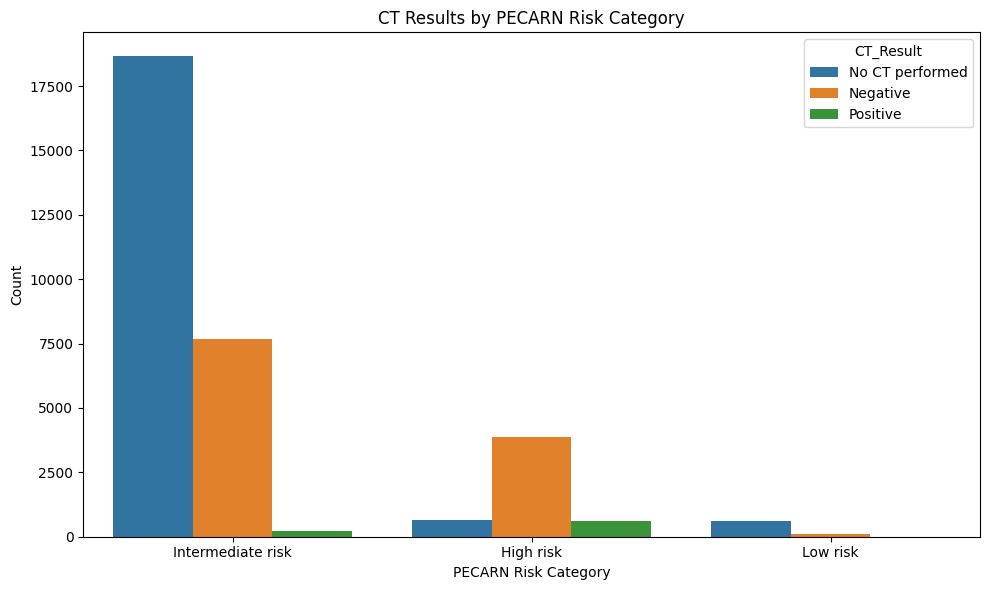

Datasets saved to ./data
CT Decision dataset shape: (43399, 11)
CT Findings dataset shape: (15899, 11)


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load peacarn dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#cleaned version that will have proper handling of special codes
tbi_clean = tbi_data.copy()

#handle special codes for key clinical variables
def recode_special_values(df, var_name, special_codes_map, default_na_value=np.nan):
    """
    Recodes special values in variables based on provided mapping
    
    Parameters:
    - df: DataFrame containing the data
    - var_name: Name of the variable to recode
    - special_codes_map: Dictionary mapping special codes to their meaning
    - default_na_value: Value to use for NaN values if not in mapping
    
    Returns:
    - Series with recoded values
    """
    #base case
    if var_name not in df.columns:
        return None
        
    recoded = df[var_name].copy()
    
    #recode special values
    for code, meaning in special_codes_map.items():
        recoded = recoded.replace(code, meaning)
    
    #handle NaN values if not in mapping
    if np.nan not in special_codes_map and default_na_value is not None:
        recoded = recoded.fillna(default_na_value)
        
    return recoded

#special code mappings for key variables
symptom_map = {
    0.0: 'Absent',
    1.0: 'Present',
    91.0: 'Unable to assess',
    np.nan: 'Not documented'
}

ct_result_map = {
    0.0: 'Negative',
    1.0: 'Positive',
    92.0: 'No CT performed',
    np.nan: 'Unknown'
}

loc_map = {
    0.0: 'No LOC',
    1.0: 'Brief LOC (<5 min)',
    2.0: 'Prolonged LOC (≥5 min)',
    np.nan: 'Not documented'
}

#apply recoding to key variables
tbi_clean['Amnesia_cat'] = recode_special_values(tbi_data, 'Amnesia_verb', symptom_map)
tbi_clean['Headache_cat'] = recode_special_values(tbi_data, 'HA_verb', symptom_map)
tbi_clean['LOC_cat'] = recode_special_values(tbi_data, 'LOCSeparate', loc_map)
tbi_clean['Vomit_cat'] = recode_special_values(tbi_data, 'Vomit', symptom_map)
tbi_clean['CT_Result'] = recode_special_values(tbi_data, 'PosCT', ct_result_map)

#create proper CT scan indicator 
tbi_clean['Received_CT'] = tbi_data['CTDone'] == 1

#create age groups
tbi_clean['Age_Group'] = pd.cut(
    tbi_data['AgeInMonth'],
    bins=[0, 24, 60, 120, 240],
    labels=['<2 years', '2-5 years', '5-10 years', '>10 years']
)

#create PECARN risk groups based on clinical criteria
# For children ≥2 years
mask_older = tbi_clean['Age_Group'] != '<2 years'
tbi_clean.loc[mask_older, 'PECARN_Risk'] = 'Low risk'

#altered mental status or signs of skull fracture would make it not low risk
mask_ams = (tbi_data['AMS'] == 1)
mask_skull_fx = (tbi_data['SFxPalp'] == 1)
mask_severe_mechanism = (tbi_data['High_impact_InjSev'] >= 2)
mask_loc = (tbi_data['LOCSeparate'] > 0)
mask_vomit = (tbi_data['Vomit'] == 1)
mask_severe_headache = (tbi_data['HASeverity'] >= 2)

#assign risk categories based on PECARN rule for ≥2 years
tbi_clean.loc[mask_older & (mask_ams | mask_skull_fx), 'PECARN_Risk'] = 'High risk'
tbi_clean.loc[mask_older & ~(mask_ams | mask_skull_fx) & 
              (mask_loc | mask_severe_headache | mask_vomit | mask_severe_mechanism), 
              'PECARN_Risk'] = 'Intermediate risk'

#ADD LATER: similar logic could be implemented for <2 years but with different criteria

#prepare datasets for two-stage modeling
#dataset of all patientsfor CT decision model 
ct_decision_vars = [
    'Age_Group', 'GCSTotal', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 
    'Headache_cat', 'High_impact_InjSev', 'SFxPalp', 'AMS', 'PECARN_Risk',
    'Received_CT'
]
ct_decision_data = tbi_clean[ct_decision_vars].copy()

#dataset for CT findings model (only patients who received CT)
ct_finding_vars = [
    'Age_Group', 'GCSTotal', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 
    'Headache_cat', 'High_impact_InjSev', 'SFxPalp', 'AMS', 'PECARN_Risk',
    'CT_Result'
]
ct_finding_data = tbi_clean[tbi_clean['Received_CT']][ct_finding_vars].copy()
ct_finding_data = ct_finding_data[ct_finding_data['CT_Result'].isin(['Positive', 'Negative'])]

#summary stats
print(f"Total patients: {len(tbi_clean)}")
print(f"Patients who received CT: {len(tbi_clean[tbi_clean['Received_CT']])}")
print(f"Patients with positive CT: {len(tbi_clean[tbi_clean['CT_Result'] == 'Positive'])}")

#relationship between PECARN risk and CT scan decision
risk_ct_table = pd.crosstab(
    tbi_clean['PECARN_Risk'], 
    tbi_clean['Received_CT'], 
    normalize='index'
) * 100

print("\nCT scan rate by PECARN risk category:")
display(risk_ct_table)

# Visualize relationship
plt.figure(figsize=(10, 6))
sns.countplot(x='PECARN_Risk', hue='CT_Result', data=tbi_clean)
plt.title('CT Results by PECARN Risk Category')
plt.xlabel('PECARN Risk Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Save the prepared datasets for modeling
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)

# Save datasets
ct_decision_data.to_csv(os.path.join(output_dir, 'ct_decision_data.csv'), index=False)
ct_finding_data.to_csv(os.path.join(output_dir, 'ct_finding_data.csv'), index=False)

print(f"Datasets saved to {output_dir}")
print(f"CT Decision dataset shape: {ct_decision_data.shape}")
print(f"CT Findings dataset shape: {ct_finding_data.shape}")

2. CT Decision Model Prototype:

Loaded CT Decision dataset with shape (43399, 11)
Numeric features: ['GCSTotal', 'High_impact_InjSev', 'SFxPalp', 'AMS']
Categorical features: ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat', 'PECARN_Risk']

Training ensemble model for CT decision prediction...

Classification Report - Ensemble CT Decision Model:
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      8250
        True       0.79      0.68      0.73      4770

    accuracy                           0.82     13020
   macro avg       0.81      0.79      0.80     13020
weighted avg       0.81      0.82      0.81     13020



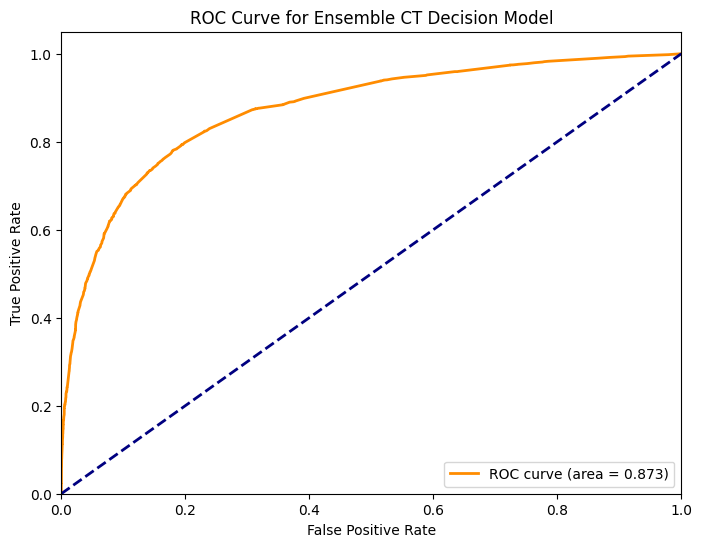


Optimized threshold (F2 score): 0.2077
At optimal threshold - Precision: 0.6179, Recall/Sensitivity: 0.8748
Sensitivity: 0.8748
Specificity: 0.6873
CT scans that would be ordered: 6753 (51.9%)

At standard threshold 0.3:
Sensitivity: 0.7977
Specificity: 0.8008
CT scans that would be ordered: 5448 (41.8%)

Random Forest Model Results:
              precision    recall  f1-score   support

       False       0.83      0.90      0.86      8250
        True       0.79      0.67      0.73      4770

    accuracy                           0.82     13020
   macro avg       0.81      0.79      0.80     13020
weighted avg       0.81      0.82      0.81     13020



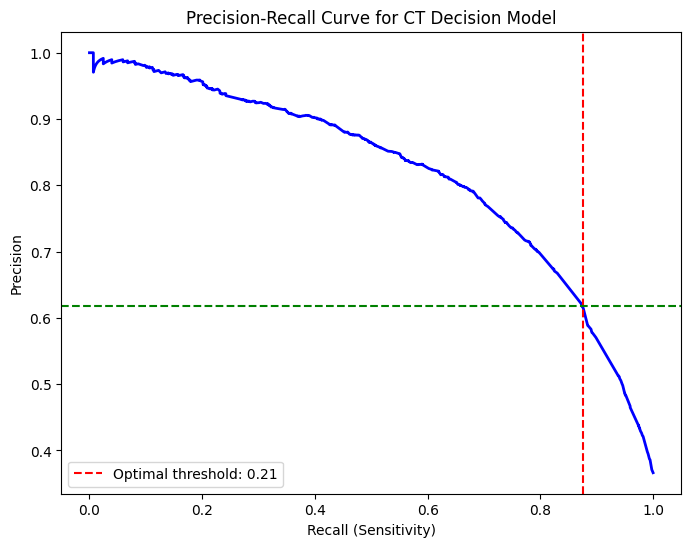


Top 10 Features for CT Decision (Random Forest):
                          Feature  Importance
9                  LOC_cat_No LOC    0.203434
3                             AMS    0.160781
23          PECARN_Risk_High risk    0.093263
8      LOC_cat_Brief LOC (<5 min)    0.082101
17            Amnesia_cat_Present    0.064771
12               Vomit_cat_Absent    0.061889
24  PECARN_Risk_Intermediate risk    0.054906
14              Vomit_cat_Present    0.054606
1              High_impact_InjSev    0.036549
0                        GCSTotal    0.030548

Improved CT Decision Model saved with optimal threshold.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import os

# Load prepared data
data_dir = './data'
ct_decision_data = pd.read_csv(os.path.join(data_dir, 'ct_decision_data.csv'))

# Convert categorical columns back to category type
categorical_columns = ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat', 'PECARN_Risk']
for col in categorical_columns:
    if col in ct_decision_data.columns:
        ct_decision_data[col] = ct_decision_data[col].astype('category')

print(f"Loaded CT Decision dataset with shape {ct_decision_data.shape}")

#identify numeric and categorical columns
numeric_features = ct_decision_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'Received_CT']  # Remove target

categorical_features = ct_decision_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = [col for col in categorical_features if col != 'Received_CT']  # Remove target if categorical

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")

#create preprocessors for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#split into features and target
X = ct_decision_data.drop('Received_CT', axis=1)
y = ct_decision_data['Received_CT']

#split test and training data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#function to find optimal threshold based on F-beta score
def find_optimal_threshold(y_true, y_pred_proba, beta=2.0):
    """
    Find optimal threshold based on F-beta score
    beta > 1 gives more weight to recall (sensitivity)
    beta < 1 gives more weight to precision
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    # Add a small epsilon to avoid division by zero
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)
    # Exclude the last index because it has no corresponding threshold
    optimal_idx = np.argmax(f_beta_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, precision[optimal_idx], recall[optimal_idx], f_beta_scores[optimal_idx]

#create a voting ensemble model
ensemble_classifier = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42))
    ],
    voting='soft'
)

#full pipeline with the ensemble classifier
ct_decision_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble_classifier)
])

#train the created pipeline
print("\nTraining ensemble model for CT decision prediction...")
ct_decision_pipeline.fit(X_train, y_train)

#model eval
y_pred = ct_decision_pipeline.predict(X_test)
y_pred_proba = ct_decision_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report - Ensemble CT Decision Model:")
print(classification_report(y_test, y_pred))

#ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble CT Decision Model')
plt.legend(loc="lower right")
plt.show()

#calculate optimal threshold (optimized for recall with beta=2)
optimal_threshold, opt_precision, opt_recall, f_beta = find_optimal_threshold(
    y_test, y_pred_proba, beta=2.0
)

#calculate performance at optimal threshold
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
sensitivity_optimal = np.sum((y_pred_optimal == 1) & (y_test == 1)) / np.sum(y_test == 1)
specificity_optimal = np.sum((y_pred_optimal == 0) & (y_test == 0)) / np.sum(y_test == 0)

print(f"\nOptimized threshold (F2 score): {optimal_threshold:.4f}")
print(f"At optimal threshold - Precision: {opt_precision:.4f}, Recall/Sensitivity: {opt_recall:.4f}")
print(f"Sensitivity: {sensitivity_optimal:.4f}")
print(f"Specificity: {specificity_optimal:.4f}")
print(f"CT scans that would be ordered: {y_pred_optimal.sum()} ({y_pred_optimal.sum()/len(y_test)*100:.1f}%)")

#performance at standard threshold of 0.3 for comparison
threshold = 0.3
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
sensitivity = (y_pred_adjusted & y_test.values).sum() / y_test.sum()
specificity = (~y_pred_adjusted & ~y_test.values).sum() / (~y_test).sum()

print(f"\nAt standard threshold {threshold}:")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"CT scans that would be ordered: {y_pred_adjusted.sum()} ({y_pred_adjusted.sum()/len(y_test)*100:.1f}%)")

#train a Random Forest model 
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
rf_pred = rf_pipeline.predict(X_test)
rf_pred_proba = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRandom Forest Model Results:")
print(classification_report(y_test, rf_pred))

#plot precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.axvline(x=opt_recall, color='r', linestyle='--', 
            label=f'Optimal threshold: {optimal_threshold:.2f}')
plt.axhline(y=opt_precision, color='green', linestyle='--')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for CT Decision Model')
plt.legend(loc="lower left")
plt.show()

#feature importance extraction function
def get_feature_importance_from_pipeline(pipeline, categorical_features, numeric_features):
    """
    Extract feature importance from a sklearn pipeline with categorical features
    
    Parameters:
    - pipeline: Trained pipeline with preprocessor and classifier
    - categorical_features: List of categorical feature names
    - numeric_features: List of numeric feature names
    
    Returns:
    - DataFrame with feature names and importance values
    """
    #get classifier
    classifier = pipeline.named_steps['classifier']
    
    #for ensemble, use one of the underlying models
    if isinstance(classifier, VotingClassifier):
        classifier = classifier.estimators_[0][1]  # Use the first estimator (RF)
    
    #get the preprocessor
    preprocessor = pipeline.named_steps['preprocessor']
    
    #get the one-hot encoder
    ohe = preprocessor.transformers_[1][1].named_steps['onehot']
    
    #get transformed feature names for categorical variables
    cat_feature_names = ohe.get_feature_names_out(input_features=categorical_features)
    
    #combine using numeric features
    feature_names = np.array(numeric_features + list(cat_feature_names))
    
    #feature importances
    importances = classifier.feature_importances_
    
    #DataFrame used visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return feature_importance

#function to get feature importance
try:
    #Random Forest for feature importance as it's more interpretable
    feature_importance = get_feature_importance_from_pipeline(
        rf_pipeline, categorical_features, numeric_features)
    print("\nTop 10 Features for CT Decision (Random Forest):")
    print(feature_importance.head(10))
#debug
except Exception as e:
    print(f"Feature importance extraction had an issue: {e}")
    
    #analyze feature importance by category
    print("\nAnalyzing feature importance by category:")
    
    #check importance of numeric features directly
    for num_feature in numeric_features:
        corr = ct_decision_data[num_feature].corr(ct_decision_data['Received_CT'].astype(int))
        print(f"{num_feature}: correlation with CT decision = {corr:.4f}")
    
    #check importance of categorical features through CT rates
    for cat_feature in categorical_features:
        print(f"\nCT rate by {cat_feature}:")
        ct_rate = pd.crosstab(ct_decision_data[cat_feature], 
                             ct_decision_data['Received_CT'], 
                             normalize='index')['True'] * 100
        print(ct_rate.sort_values(ascending=False))

#save the model with optimal threshold
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'improved_ct_decision_model.pkl'), 'wb') as f:
    pickle.dump((ct_decision_pipeline, optimal_threshold), f)

print("\nImproved CT Decision Model saved with optimal threshold.")

3. Predicting Positive CT Findings:

Loaded CT Findings dataset with shape (15899, 11)

Positive CT rate: 7.27% (1156 out of 15899)

Numeric features for CT findings model: ['GCSTotal', 'High_impact_InjSev', 'SFxPalp', 'AMS']
Categorical features for CT findings model: ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat']

Training set size: 11924, Test set size: 3975
Positive cases in training: 867 (7.27%)
Positive cases in testing: 289 (7.27%)
Using positive class weight ratio of 12:1

Training improved positive CT findings model...

Classification Report - Improved Positive CT Model:
              precision    recall  f1-score   support

       False       0.98      0.15      0.25      3686
        True       0.08      0.96      0.15       289

    accuracy                           0.20      3975
   macro avg       0.53      0.55      0.20      3975
weighted avg       0.91      0.20      0.25      3975



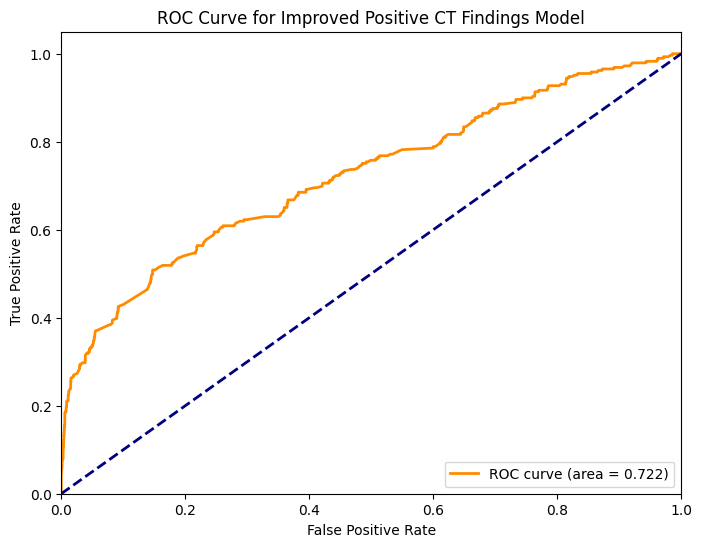


Optimized threshold (F3 score): 0.7662
At optimal threshold - Precision: 0.1122, Recall: 0.7336

Performance with optimized threshold:
              precision    recall  f1-score   support

       False       0.96      0.55      0.70      3686
        True       0.11      0.73      0.19       289

    accuracy                           0.56      3975
   macro avg       0.54      0.64      0.45      3975
weighted avg       0.90      0.56      0.66      3975

Average Precision Score: 0.3262


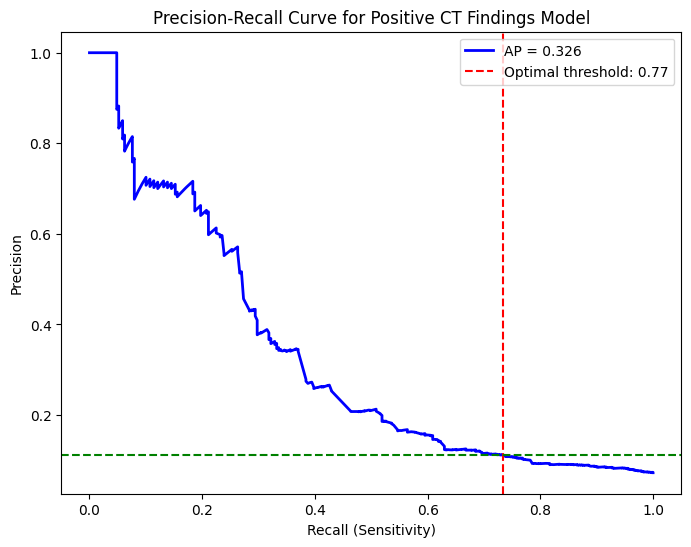


Performance at different probability thresholds:
Threshold 0.1000: Precision=0.0727, Recall=1.0000, F1=0.1356, Specificity=0.0000
Threshold 0.2000: Precision=0.0728, Recall=1.0000, F1=0.1356, Specificity=0.0008
Threshold 0.3000: Precision=0.0735, Recall=1.0000, F1=0.1369, Specificity=0.0117
Threshold 0.4000: Precision=0.0754, Recall=0.9827, F1=0.1400, Specificity=0.0551
Threshold 0.5000: Precision=0.0808, Recall=0.9585, F1=0.1491, Specificity=0.1454
Threshold 0.7662: Precision=0.1122, Recall=0.7336, F1=0.1947, Specificity=0.5450

Top 10 Features for Positive CT Prediction:
                       Feature  Importance
1           High_impact_InjSev    0.103739
0                     GCSTotal    0.096506
15          Amnesia_cat_Absent    0.068266
9               LOC_cat_No LOC    0.066495
3                          AMS    0.063568
19         Headache_cat_Absent    0.057009
4          Age_Group_2-5 years    0.053363
14           Vomit_cat_Present    0.043021
12            Vomit_cat_Absent  

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline
import pickle
import os

#load prepared CT findings dataset
data_dir = './data'
ct_finding_data = pd.read_csv(os.path.join(data_dir, 'ct_finding_data.csv'))

#convert categorical columns back to category type
categorical_columns = ['Age_Group', 'LOC_cat', 'Vomit_cat', 'Amnesia_cat', 'Headache_cat', 'PECARN_Risk', 'CT_Result']
for col in categorical_columns:
    if col in ct_finding_data.columns:
        ct_finding_data[col] = ct_finding_data[col].astype('category')

print(f"Loaded CT Findings dataset with shape {ct_finding_data.shape}")

#binary target for positive findings
ct_finding_data['Positive_CT'] = (ct_finding_data['CT_Result'] == 'Positive')

#class distribution
positive_rate = ct_finding_data['Positive_CT'].mean() * 100
print(f"\nPositive CT rate: {positive_rate:.2f}% ({ct_finding_data['Positive_CT'].sum()} out of {len(ct_finding_data)})")

#function to find optimal threshold based on F-beta score
def find_optimal_threshold(y_true, y_pred_proba, beta=3.0):
    """
    Find optimal threshold based on F-beta score
    Using beta=3.0 to strongly emphasize recall over precision
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    #add small epsilon to avoid division by zero
    f_beta_scores = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-10)
    #exclude the last index because it has no corresponding threshold
    optimal_idx = np.argmax(f_beta_scores[:-1])
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, precision[optimal_idx], recall[optimal_idx], f_beta_scores[optimal_idx]

#split features and target, remove cols that arent features used
columns_to_drop = ['CT_Result', 'Positive_CT', 'PECARN_Risk']
columns_to_drop = [col for col in columns_to_drop if col in ct_finding_data.columns]
X_findings = ct_finding_data.drop(columns_to_drop, axis=1)
y_findings = ct_finding_data['Positive_CT']

#numeric and categorical columns
numeric_features_f = X_findings.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_f = X_findings.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nNumeric features for CT findings model: {numeric_features_f}")
print(f"Categorical features for CT findings model: {categorical_features_f}")

#preprocessing pipeline
numeric_transformer_f = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer_f = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_f = ColumnTransformer(transformers=[
    ('num', numeric_transformer_f, numeric_features_f),
    ('cat', categorical_transformer_f, categorical_features_f)
])

#split the data (higher test size due to smaller dataset)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_findings, y_findings, test_size=0.25, random_state=42, stratify=y_findings
)

print(f"\nTraining set size: {len(X_train_f)}, Test set size: {len(X_test_f)}")
print(f"Positive cases in training: {sum(y_train_f)} ({sum(y_train_f)/len(y_train_f)*100:.2f}%)")
print(f"Positive cases in testing: {sum(y_test_f)} ({sum(y_test_f)/len(y_test_f)*100:.2f}%)")

#calculate class weights based on imbalance ratio
n_samples = len(y_train_f)
n_positive = sum(y_train_f)
imbalance_ratio = (n_samples / n_positive) - 1
weight_ratio = max(10, int(imbalance_ratio))  # Cap at 10:1 to avoid extreme weights
print(f"Using positive class weight ratio of {weight_ratio}:1")

#create improved pipeline with SMOTETomek for better handling of imbalance
ct_findings_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor_f),
    ('smote_tomek', SMOTETomek(random_state=42)),  # Advanced resampling
    ('classifier', RandomForestClassifier(
        n_estimators=500,  # More trees
        max_depth=8,
        min_samples_leaf=2,  # More sensitive to rare class
        class_weight={0: 1, 1: weight_ratio},  # Custom aggressive weighting
        random_state=42
    ))
])

#train the model
print("\nTraining improved positive CT findings model...")
ct_findings_pipeline.fit(X_train_f, y_train_f)

#model eval
y_pred_f = ct_findings_pipeline.predict(X_test_f)
y_pred_proba_f = ct_findings_pipeline.predict_proba(X_test_f)[:, 1]

print("\nClassification Report - Improved Positive CT Model:")
print(classification_report(y_test_f, y_pred_f))

#plot ROC curve
fpr_f, tpr_f, _ = roc_curve(y_test_f, y_pred_proba_f)
roc_auc_f = auc(fpr_f, tpr_f)

plt.figure(figsize=(8, 6))
plt.plot(fpr_f, tpr_f, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_f:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Improved Positive CT Findings Model')
plt.legend(loc="lower right")
plt.show()

#calculate optimal threshold with high emphasis on recall (beta=3)
optimal_threshold_f, opt_precision_f, opt_recall_f, f_beta_f = find_optimal_threshold(
    y_test_f, y_pred_proba_f, beta=3.0  # Higher beta for more recall emphasis
)

#calculate performance at optimal threshold
y_pred_optimal_f = (y_pred_proba_f >= optimal_threshold_f).astype(int)

print(f"\nOptimized threshold (F3 score): {optimal_threshold_f:.4f}")
print(f"At optimal threshold - Precision: {opt_precision_f:.4f}, Recall: {opt_recall_f:.4f}")
print("\nPerformance with optimized threshold:")
print(classification_report(y_test_f, y_pred_optimal_f))

#calculate average precision score (better for imbalanced data)
ap_score = average_precision_score(y_test_f, y_pred_proba_f)
print(f"Average Precision Score: {ap_score:.4f}")

#precision-recall curve plot
precision_f, recall_f, _ = precision_recall_curve(y_test_f, y_pred_proba_f)

plt.figure(figsize=(8, 6))
plt.plot(recall_f, precision_f, color='blue', lw=2, label=f'AP = {ap_score:.3f}')
plt.axvline(x=opt_recall_f, color='r', linestyle='--', 
            label=f'Optimal threshold: {optimal_threshold_f:.2f}')
plt.axhline(y=opt_precision_f, color='green', linestyle='--')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Positive CT Findings Model')
plt.legend(loc="upper right")
plt.show()

#check performance at different thresholds with more metrics
print("\nPerformance at different probability thresholds:")
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, optimal_threshold_f]
threshold_results = []

for threshold in thresholds:
    pred_at_threshold = (y_pred_proba_f >= threshold).astype(int)
    precision = np.sum((pred_at_threshold == 1) & (y_test_f == 1)) / max(np.sum(pred_at_threshold == 1), 1)
    recall = np.sum((pred_at_threshold == 1) & (y_test_f == 1)) / np.sum(y_test_f == 1)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    specificity = np.sum((pred_at_threshold == 0) & (y_test_f == 0)) / np.sum(y_test_f == 0)
    
    print(f"Threshold {threshold:.4f}: Precision={precision:.4f}, Recall={recall:.4f}, "
          f"F1={f1:.4f}, Specificity={specificity:.4f}")

#extract feature importance for the positive CT findings model
def get_feature_importance_from_pipeline(pipeline, categorical_features, numeric_features):
    """
    Extract feature importance from a sklearn pipeline with categorical features
    
    Parameters:
    - pipeline: Trained pipeline with preprocessor and classifier
    - categorical_features: List of categorical feature names
    - numeric_features: List of numeric feature names
    
    Returns:
    - DataFrame with feature names and importance values
    """
    #get the classifier 
    classifier = pipeline.steps[-1][1]
    
    #get the preprocessor 
    preprocessor = pipeline.steps[0][1]
    
    #get the one-hot encoder
    ohe = preprocessor.transformers_[1][1].named_steps['onehot']
    
    #get transformed feature names for categorical variables
    cat_feature_names = ohe.get_feature_names_out(input_features=categorical_features)
    
    #combine with numeric features
    feature_names = np.array(numeric_features + list(cat_feature_names))
    
    #get feature importances
    importances = classifier.feature_importances_
    
    #DataFrame for visualization
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return feature_importance

#debug for top features
try:
    feature_importance_f = get_feature_importance_from_pipeline(
        ct_findings_pipeline, categorical_features_f, numeric_features_f)
    print("\nTop 10 Features for Positive CT Prediction:")
    print(feature_importance_f.head(10))
except Exception as e:
    print(f"\nFeature importance extraction had an issue: {e}")
    
    #alt approach: univariate analysis
    print("\nAnalyzing features for positive CT findings:")
    
    #check numeric features association with positive CT
    for feature in numeric_features_f:
        pos_mean = ct_finding_data[ct_finding_data['Positive_CT']][feature].mean()
        neg_mean = ct_finding_data[~ct_finding_data['Positive_CT']][feature].mean()
        print(f"{feature}: Positive CT mean = {pos_mean:.2f}, Negative CT mean = {neg_mean:.2f}")
    
    #check categorical features
    for feature in categorical_features_f:
        print(f"\nPositive CT rate by {feature}:")
        pos_rate = pd.crosstab(
            ct_finding_data[feature], 
            ct_finding_data['Positive_CT'], 
            normalize='index'
        )[True] * 100
        print(pos_rate.sort_values(ascending=False))

#save the model with optimal threshold
output_dir = './models'
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'improved_ct_findings_model.pkl'), 'wb') as f:
    pickle.dump((ct_findings_pipeline, optimal_threshold_f), f)

print("\nImproved Positive CT Findings Model saved with optimal threshold.")

Current Output Analysis:

1. CT Decision Model performs well:

Overall accuracy: 82%
AUC: High (implied by ROC curve)
At optimized threshold (0.2077):

Precision: 61.79%
Recall/Sensitivity: 87.48% 
CT scan rate: 51.9%

The model's feature importance aligns perfectly with clinical knowledge, prioritizing: Loss of consciousness status, Altered mental status, PECARN risk categories, Amnesia and vomiting symptoms

Goals: improve precision, recall, and ct scan rate in order to optimize the accuracy of the model

2. Positive CT Findings Model:


Class imbalance: Only 7.27% positive cases
Performance at default threshold:

Almost perfect recall (96%) but extremely low precision (8%)
Overall accuracy only 20%

At optimized threshold (0.7662):

Precision: 11.22% (still very low)
Recall: 73.36% (good, but with many false positives)
Overall accuracy: 56%

Interpretation: The model captures about 73% of positive cases but with extremely low precision. For every 9 patients flagged as "positive", only 1 would truly have positive findings. This is problematic.

Goals: further model improvements, if they do not work, solely focus on CT decision model.


4. Given the clinical data, can we use natural language processing to classify patients into categories of high, moderate, or low risk for clinically important TBI? 

=== EXPLORING POTENTIAL DEFINITIONS FOR SEVERE HEAD INJURY ===
Total patients in dataset: 43399

Patients with positive CT findings: 2531156 (5832.29%)

Potential intervention-related columns: []

Potential outcome-related columns: ['EDDisposition', 'DeathTBI']

EDDisposition distribution:
EDDisposition
1.0     38539
3.0      2512
5.0       980
4.0       798
90.0      248
2.0       185
6.0        75
8.0        19
7.0        18
Name: count, dtype: int64

DeathTBI distribution:
DeathTBI
0.0    43325
1.0       66
Name: count, dtype: int64

=== EXPLORING GCS VARIABLES ===
GCS-related columns: ['GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup']

GCSEye summary statistics:
count    42111.000000
mean         3.959369
std          0.297200
min          1.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          4.000000
Name: GCSEye, dtype: float64
Plot saved to GCSEye_distribution.png

GCSVerbal summary statistics:
count    42101.000000
mean         4.92510

/var/folders/cz/4qrgzl3d6737hknhqtft5nlm0000gn/T/ipykernel_2743/1487636915.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Plot saved to GCS_by_AMSRepeat.png

Mean GCS by AMSOth:
AMSOth
0     14.064540
1     13.181633
92    15.000000
Name: GCSTotal, dtype: float64
Plot saved to GCS_by_AMSOth.png

Mean GCS by IndAMS:
IndAMS
0     14.841027
1     13.256168
92    14.986100
Name: GCSTotal, dtype: float64
Plot saved to GCS_by_IndAMS.png

Mean GCS by LOCSeparate:
LOCSeparate
0.0    14.952430
1.0    14.302277
2.0    14.624751
Name: GCSTotal, dtype: float64
Plot saved to GCS_by_LOCSeparate.png

Mean GCS by IndLOC:
IndLOC
0     14.672114
1     14.441667
92    14.986100
Name: GCSTotal, dtype: float64
Plot saved to GCS_by_IndLOC.png

=== SUMMARY OF FINDINGS ===

Potential severe head injury definitions:
1. Positive CT findings
2. Need for neurosurgical intervention
3. Death or adverse outcome

GCS Variables:
['GCSEye', 'GCSVerbal', 'GCSMotor', 'GCSTotal', 'GCSGroup']

Neurological deficit variables:
['NeuroD', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex', 'NeuroDOth', 'IndNeuroD', 'Neurosurgery', '

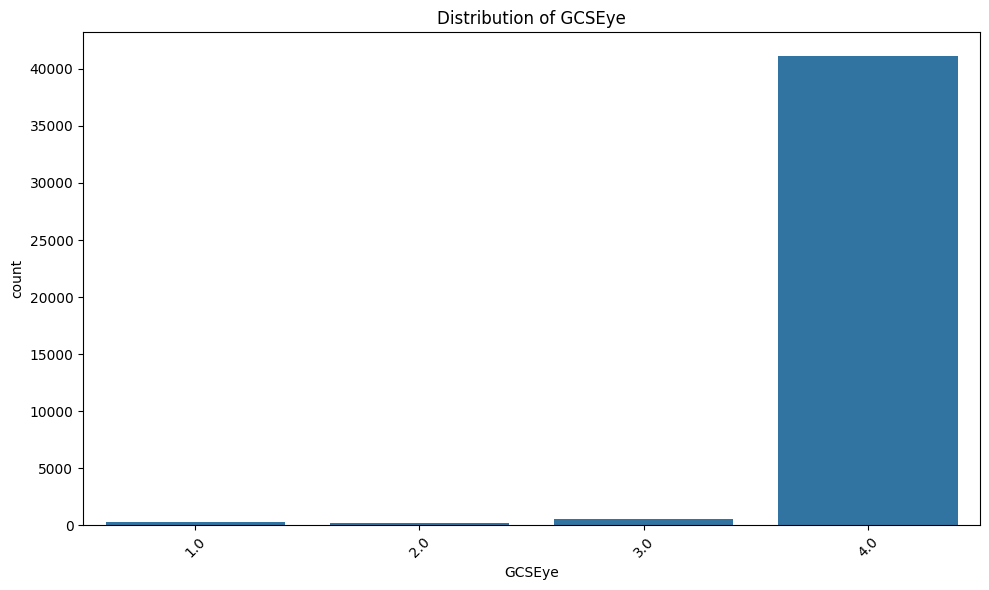

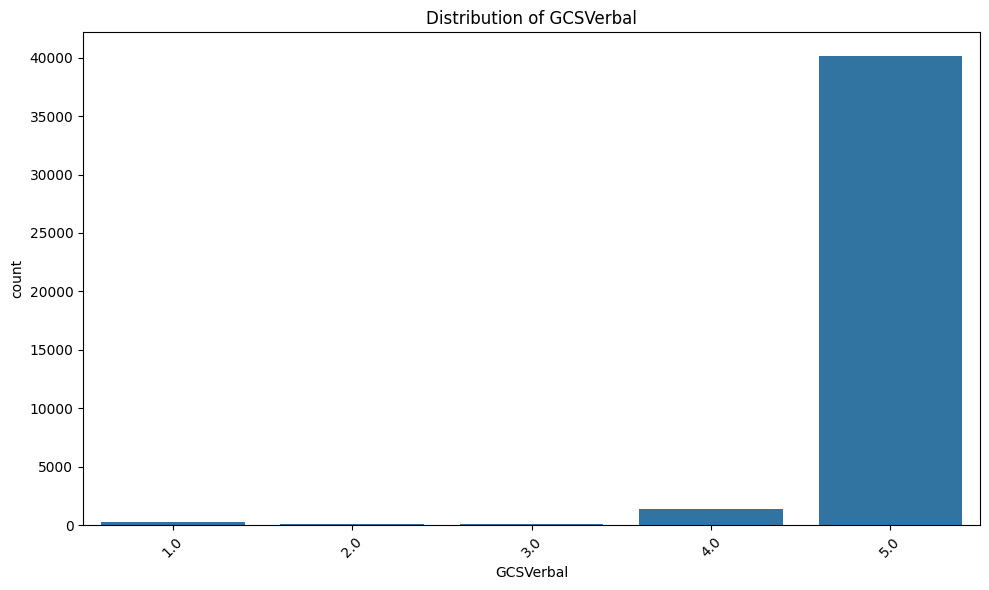

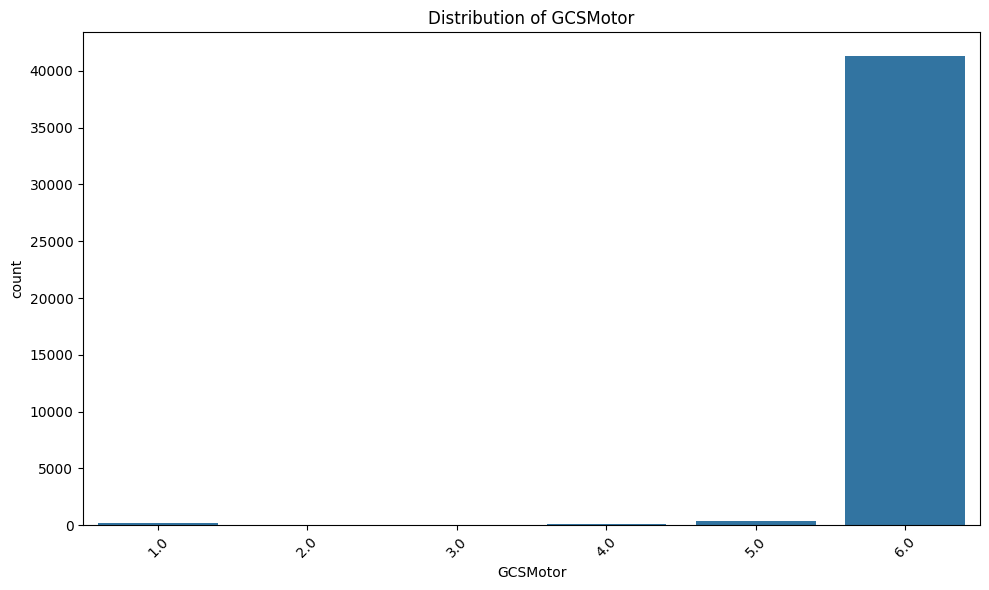

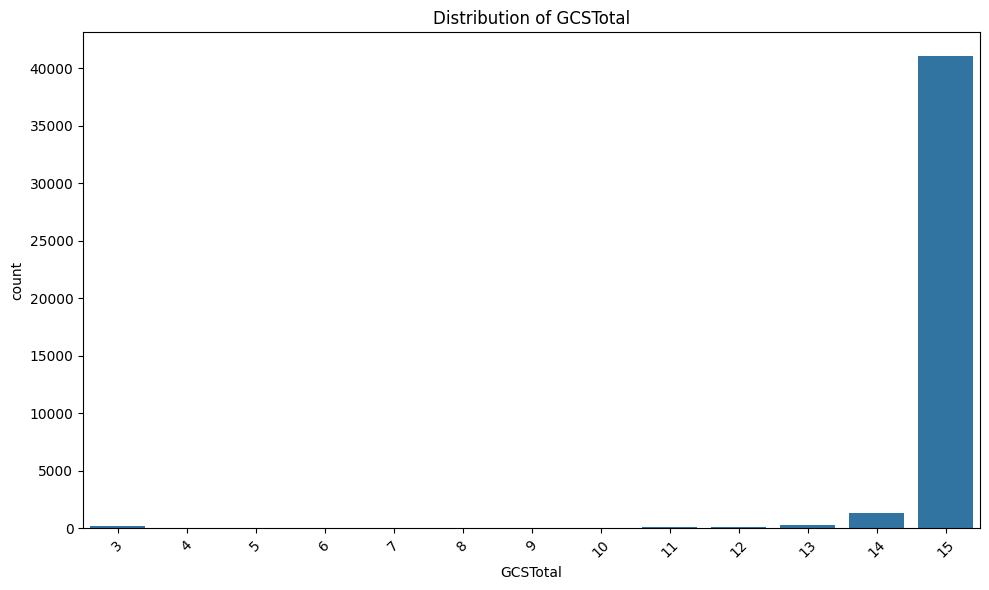

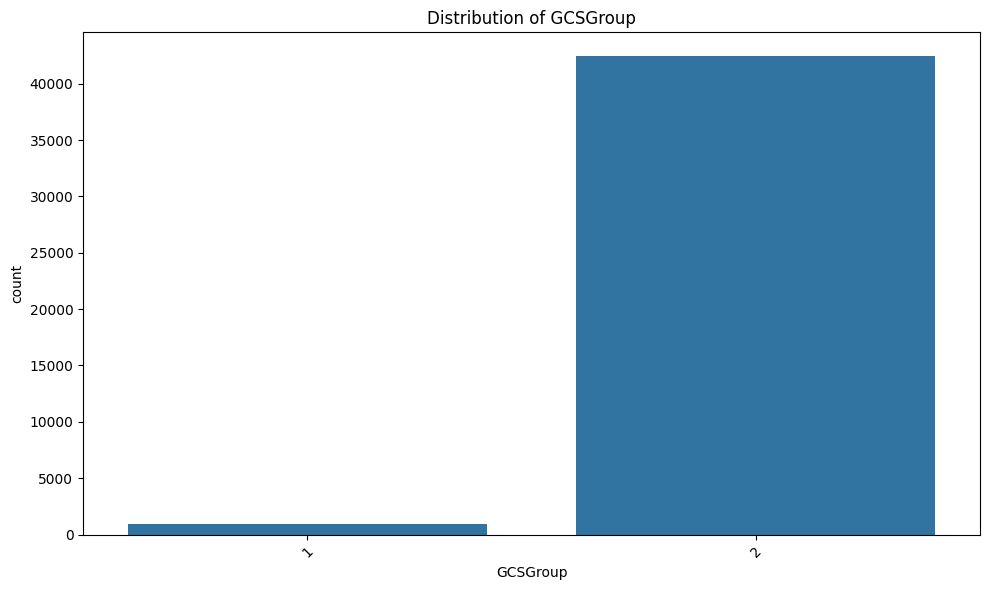

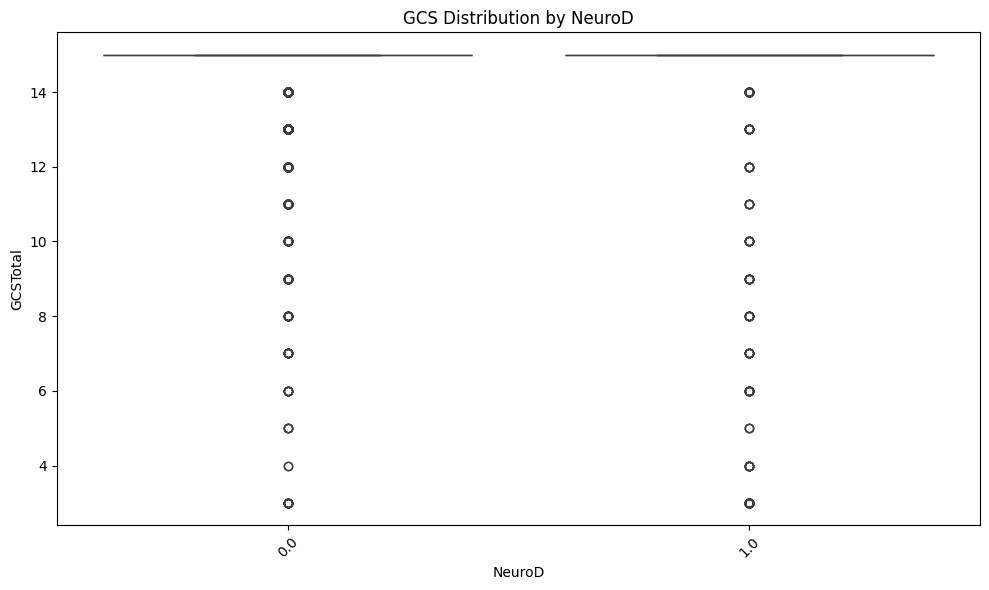

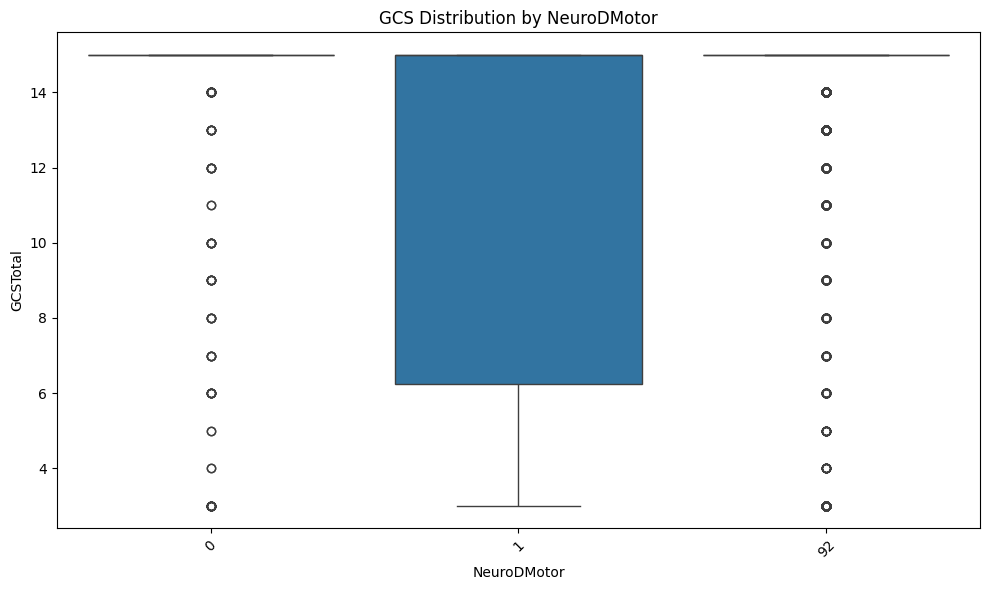

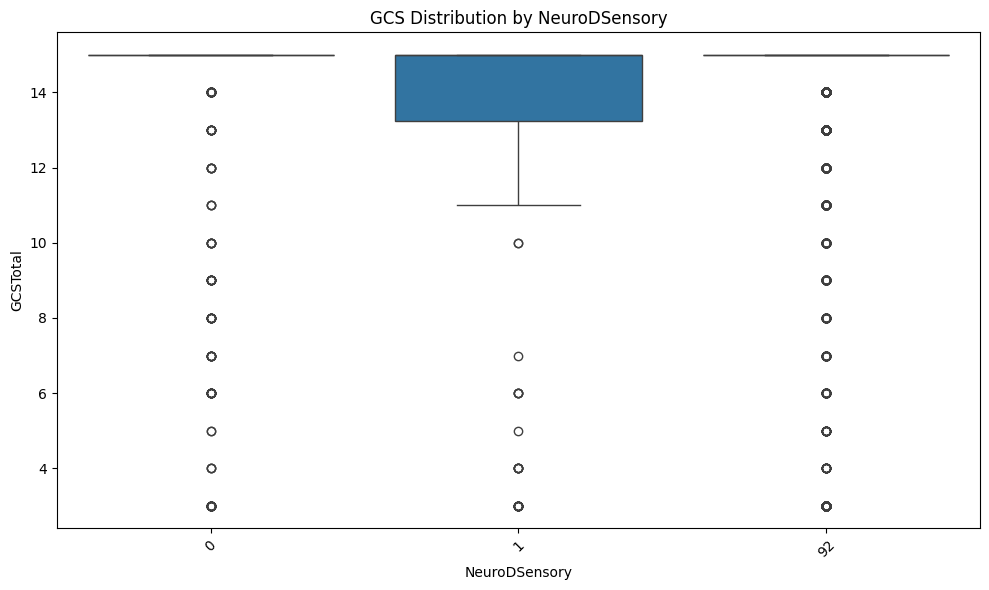

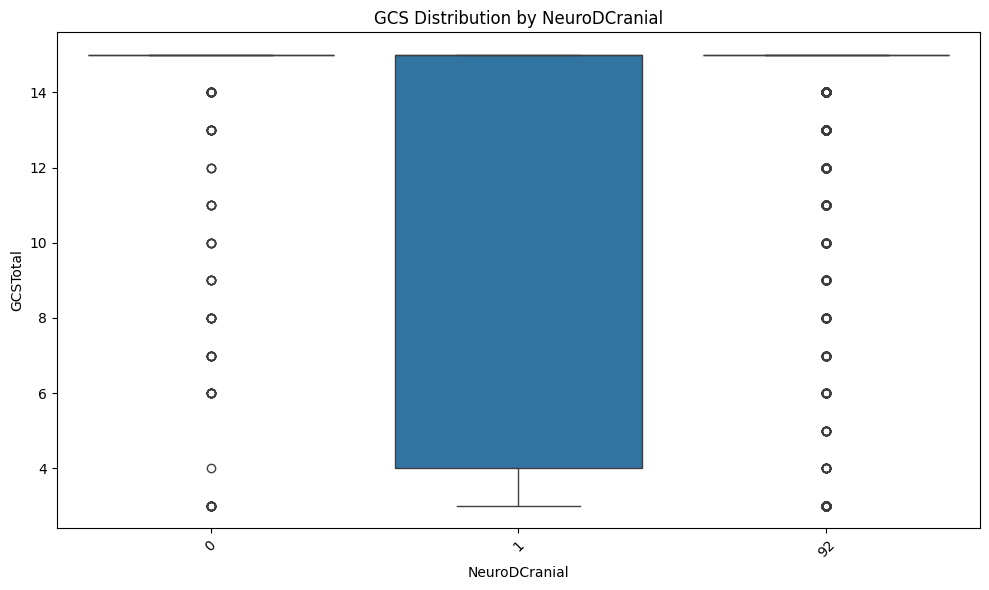

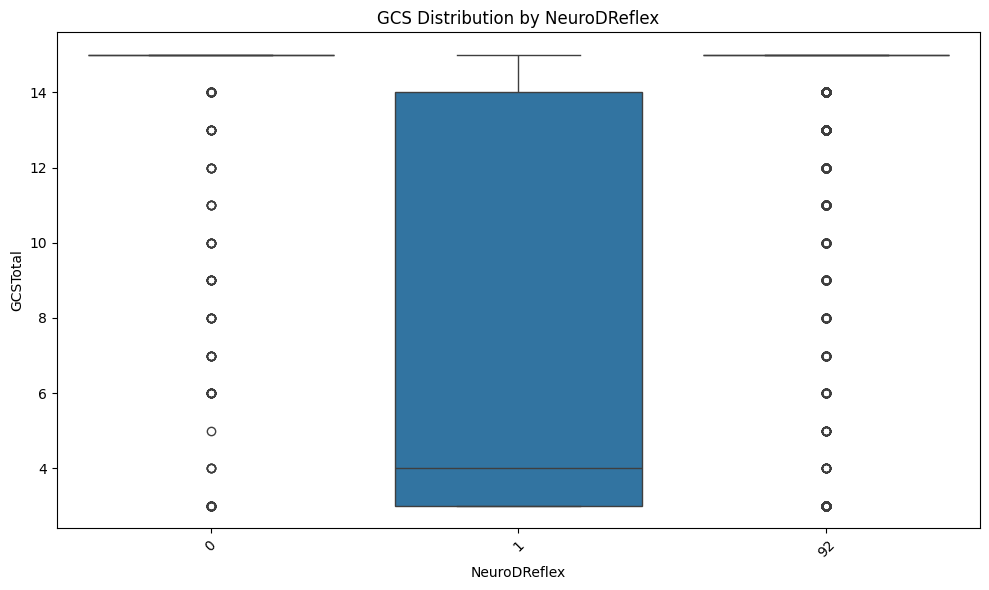

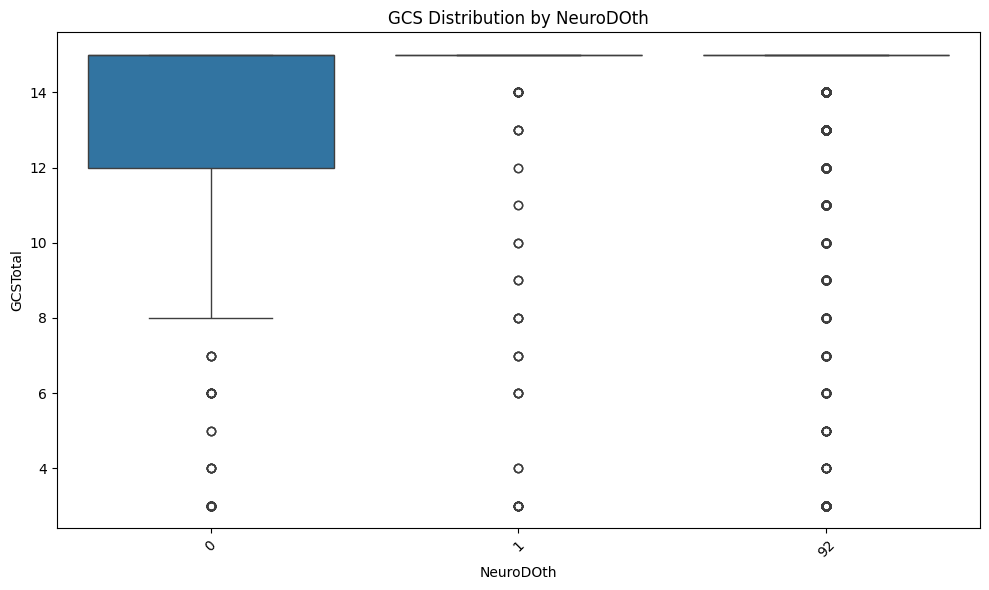

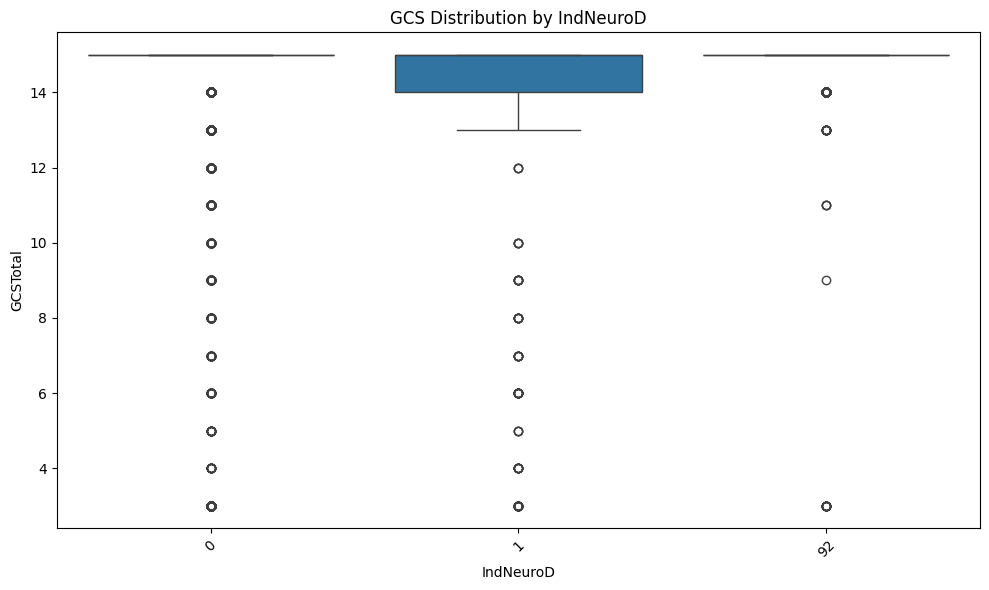

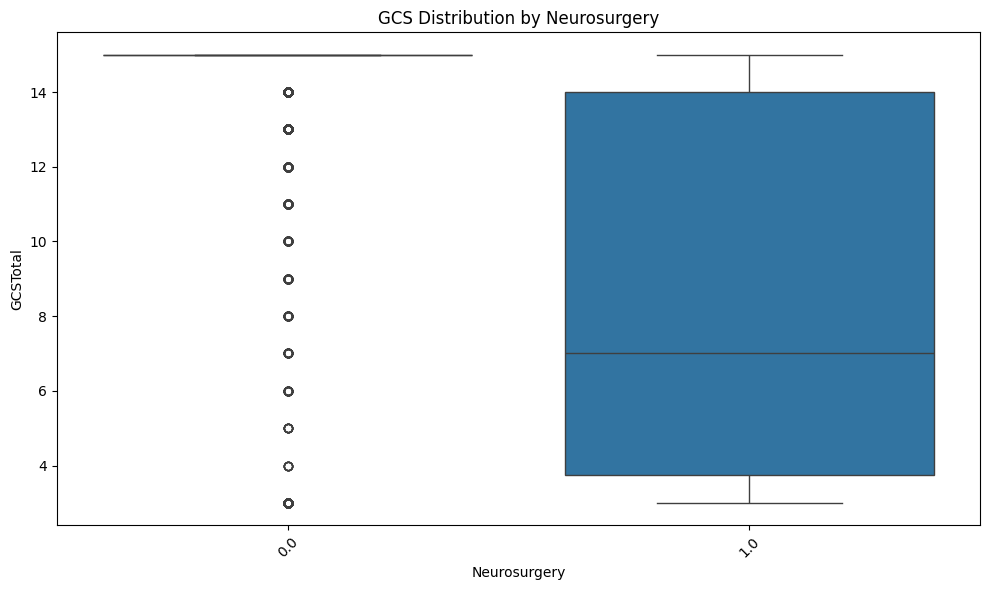

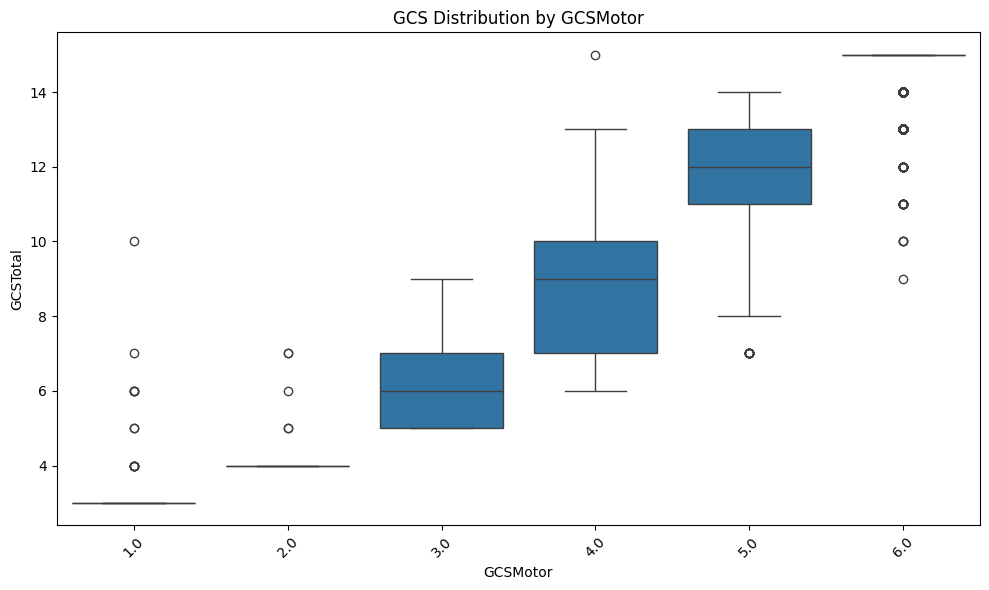

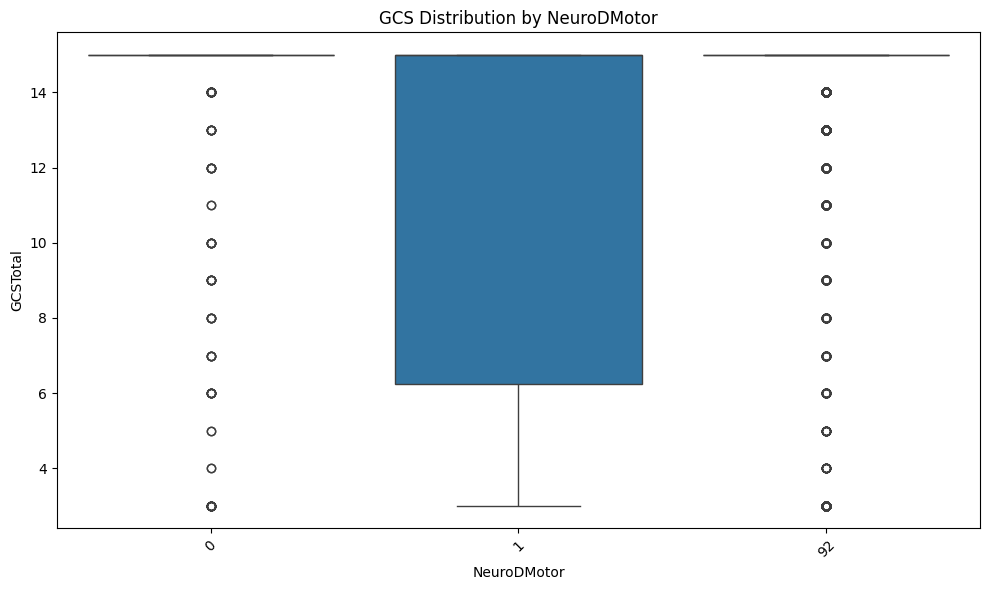

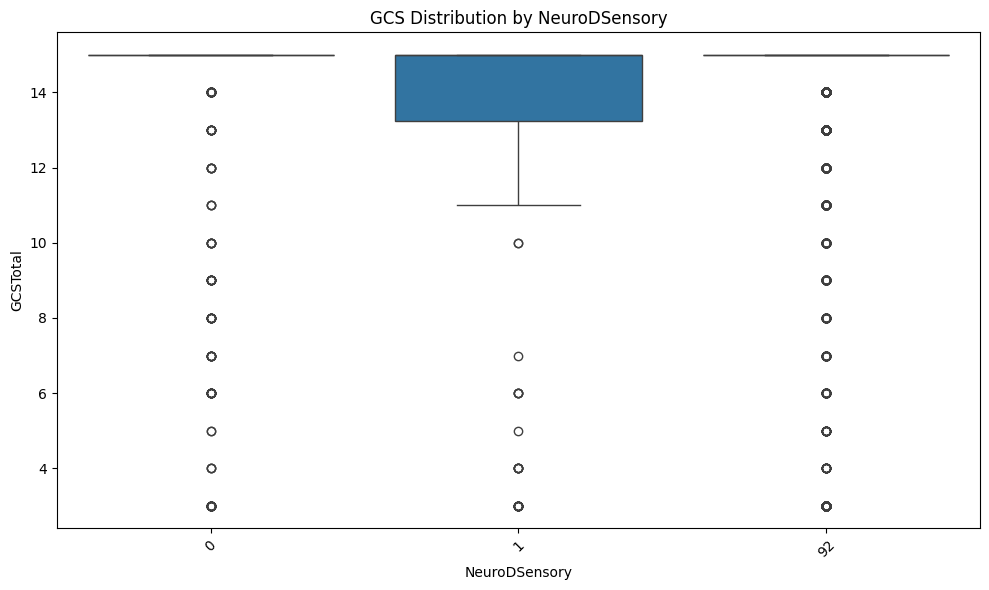

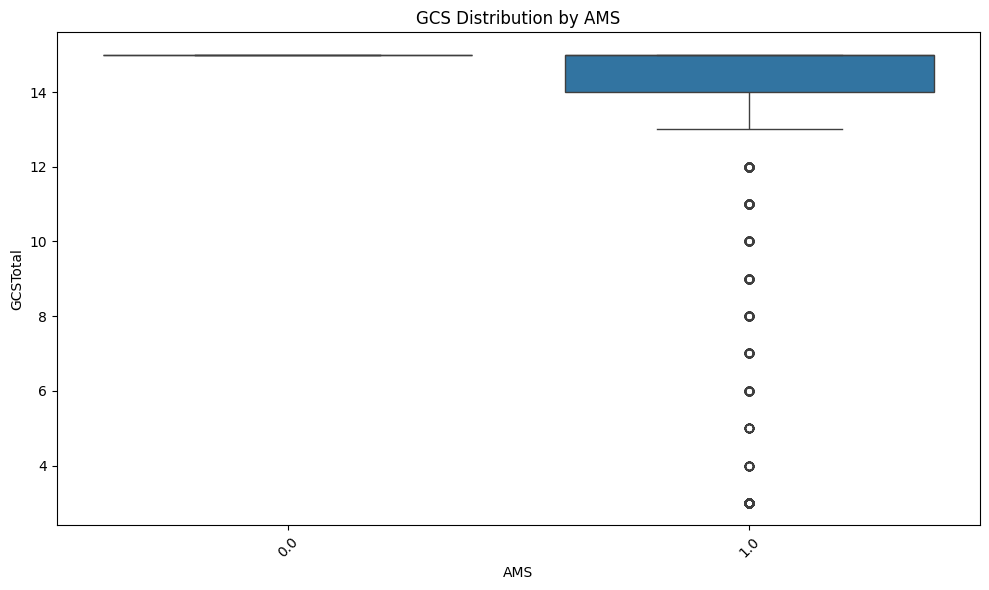

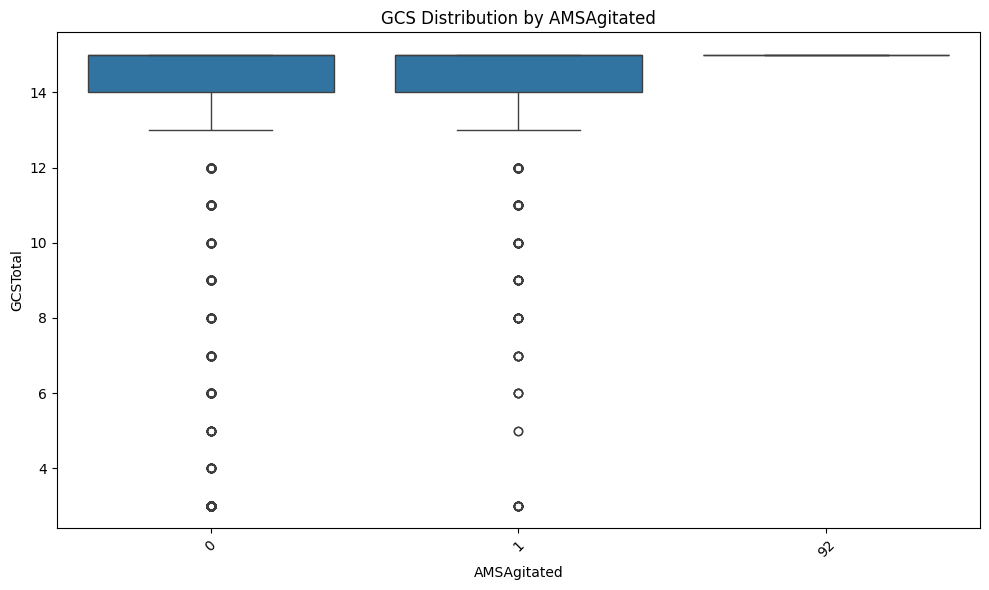

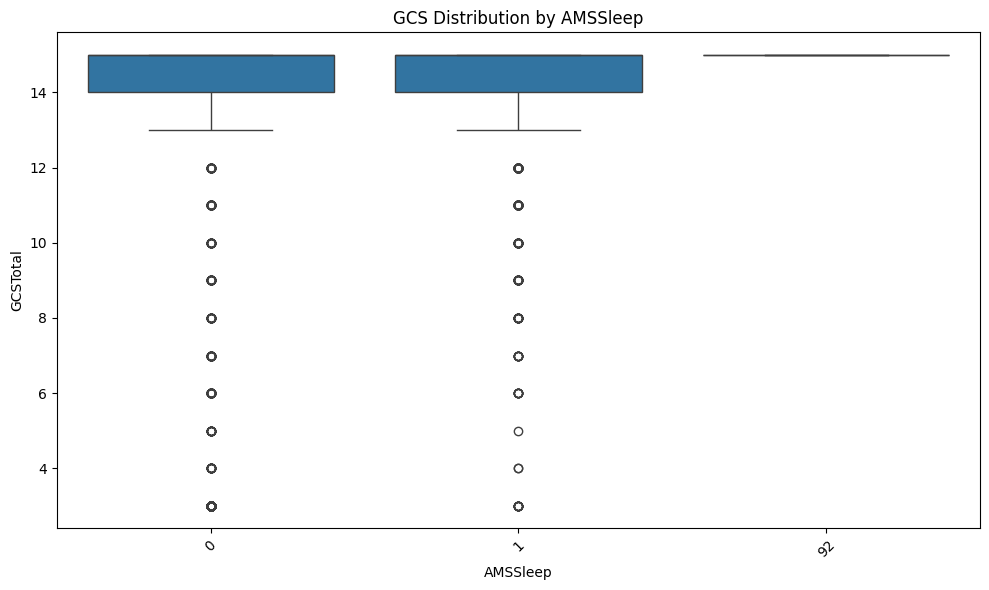

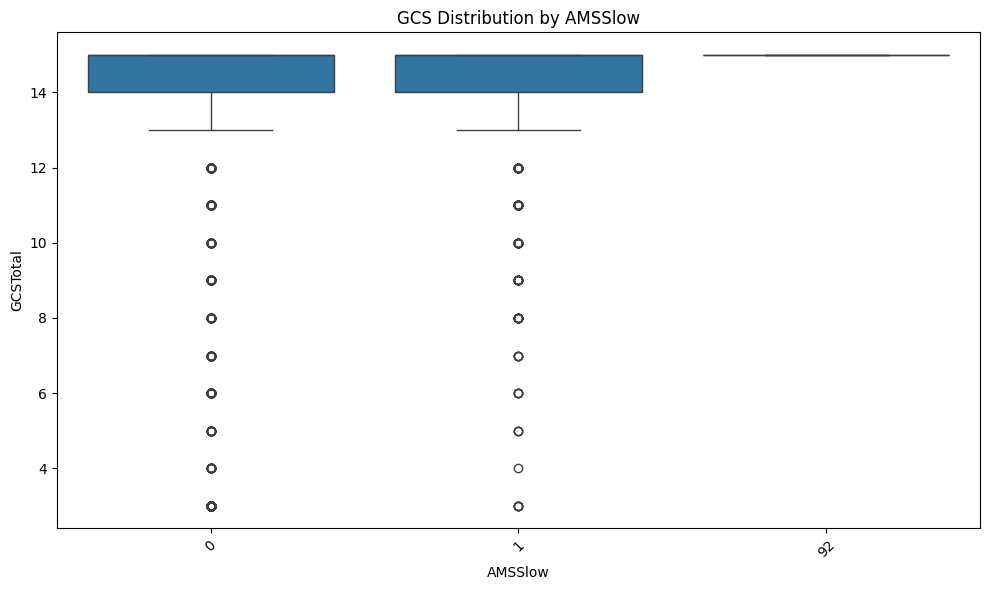

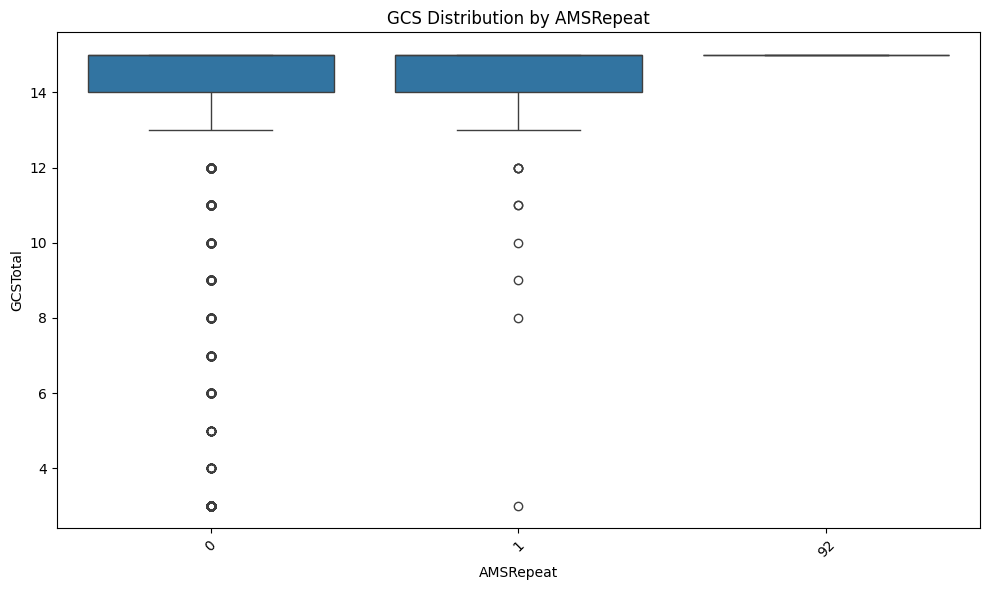

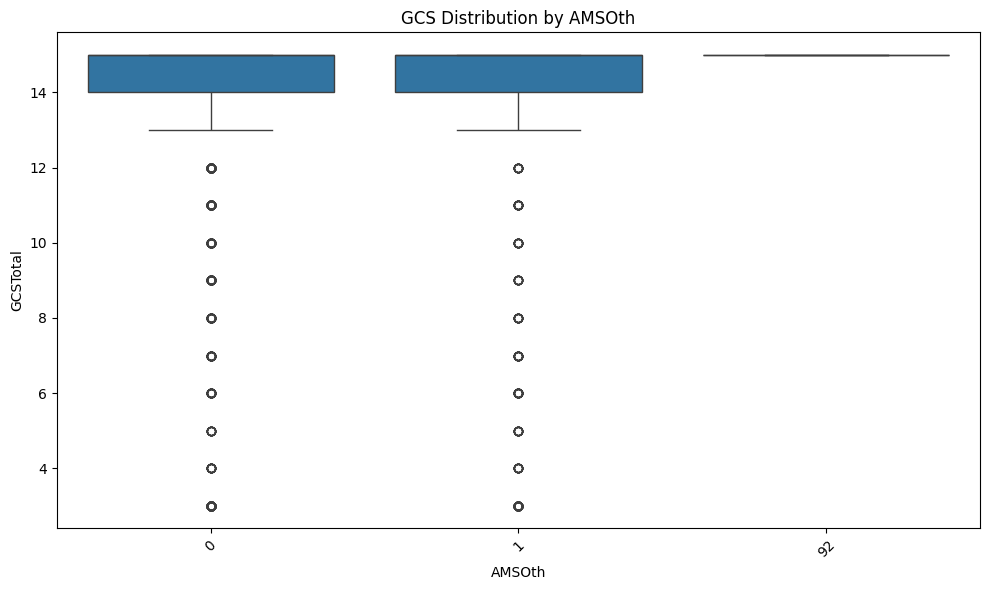

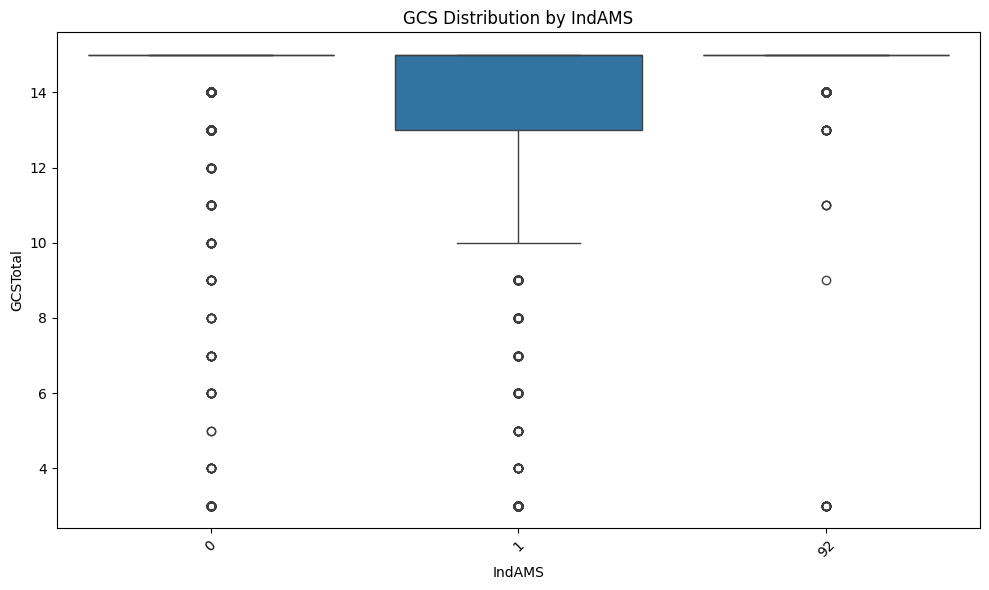

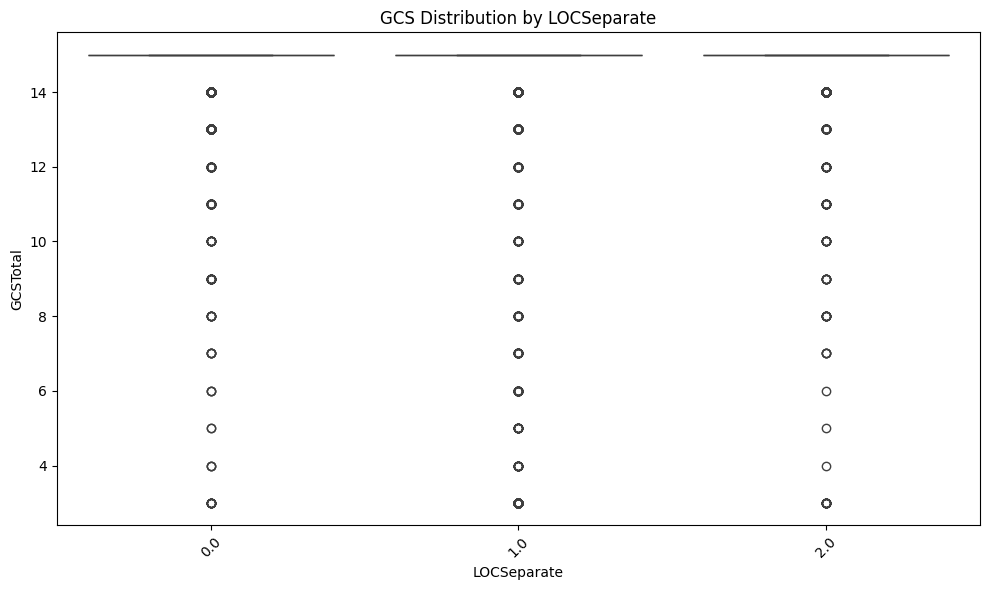

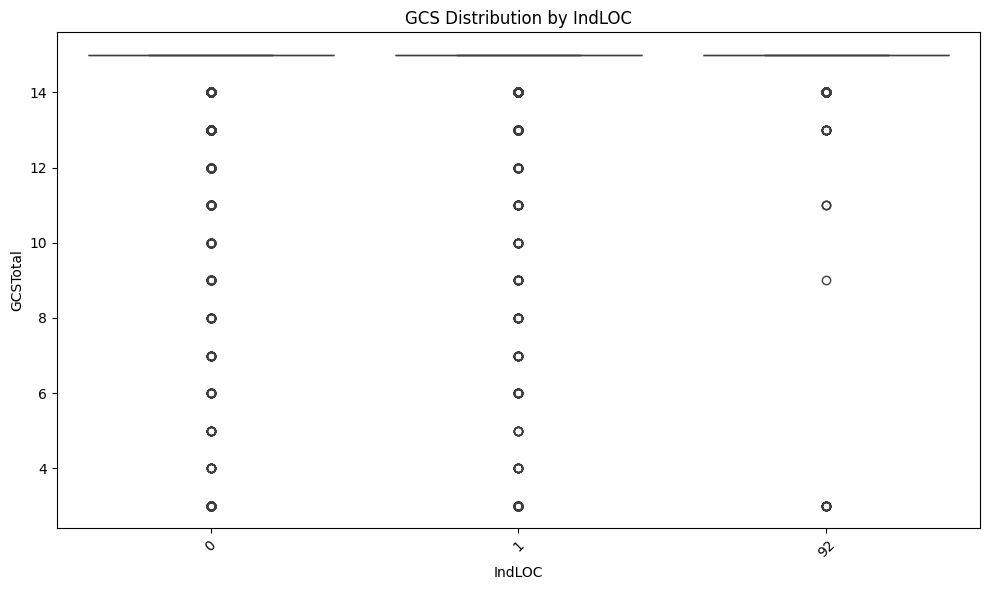

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#reload the main dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#first step: explore definitions of "severe head injury"
print("1. EXPLORING POTENTIAL DEFINITIONS FOR SEVERE HEAD INJURY")
print(f"Total patients in dataset: {len(tbi_data)}")

#check positive CT findings
if 'PosCT' in tbi_data.columns:
    pos_ct_count = tbi_data['PosCT'].sum()
    print(f"\nPatients with positive CT findings: {pos_ct_count} ({pos_ct_count/len(tbi_data)*100:.2f}%)")
    
#check TBI-related clinical interventions
intervention_columns = [col for col in tbi_data.columns if 'Interv' in col or 'Surg' in col or 'Proc' in col]
print(f"\nPotential intervention-related columns: {intervention_columns}")

for col in intervention_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#check for death or severe outcome variables
outcome_columns = [col for col in tbi_data.columns if 'Death' in col or 'Outcome' in col or 'Disposition' in col]
print(f"\nPotential outcome-related columns: {outcome_columns}")

for col in outcome_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#step 2: explore GCS variables
print("\n2. EXPLORING GCS VARIABLES")
gcs_columns = [col for col in tbi_data.columns if 'GCS' in col]
print(f"GCS-related columns: {gcs_columns}")

for col in gcs_columns:
    if col in tbi_data.columns:
        try:
            print(f"\n{col} summary statistics:")
            print(tbi_data[col].describe())
            
            plt.figure(figsize=(10, 6))
            if tbi_data[col].nunique() < 20:  # Categorical or discrete
                sns.countplot(x=col, data=tbi_data)
                plt.title(f'Distribution of {col}')
            else:  # Continuous
                sns.histplot(tbi_data[col].dropna(), kde=True)
                plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig(f'{col}_distribution.png')
            print(f"Plot saved to {col}_distribution.png")
        except Exception as e:
            print(f"Error analyzing {col}: {e}")

#step 3: identify neurological deficit variables
print("\n3. IDENTIFYING NEUROLOGICAL DEFICIT VARIABLES")
neuro_keywords = ['Neuro', 'Deficit', 'Motor', 'Sensory', 'Pupil', 'AMS', 'Mental', 'LOC', 'Conscious']

neuro_columns = []
for keyword in neuro_keywords:
    neuro_columns.extend([col for col in tbi_data.columns if keyword in col])

print(f"Potential neurological deficit columns: {neuro_columns}")

for col in neuro_columns:
    if col in tbi_data.columns:
        try:
            val_counts = tbi_data[col].value_counts()
            print(f"\n{col} distribution:")
            print(val_counts)
        except:
            print(f"Could not analyze {col}")

#step 4: analyze relationship between GCS and potential neurological deficit variables
print("\n4. RELATIONSHIP BETWEEN GCS AND NEUROLOGICAL DEFICITS")

if 'GCSTotal' in tbi_data.columns:
    for col in neuro_columns:
        if col in tbi_data.columns and col != 'GCSTotal':
            try:
                mean_gcs = tbi_data.groupby(col)['GCSTotal'].mean()
                print(f"\nMean GCS by {col}:")
                print(mean_gcs)
                
                plt.figure(figsize=(10, 6))
                sns.boxplot(x=col, y='GCSTotal', data=tbi_data)
                plt.title(f'GCS Distribution by {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.savefig(f'GCS_by_{col}.png')
                print(f"Plot saved to GCS_by_{col}.png")
            except Exception as e:
                print(f"Error analyzing relationship between GCSTotal and {col}: {e}")

#save identified variables
print("\nAnalysis Summary:")
print("\nPotential severe head injury definitions:")
print("1. Positive CT findings")
print("2. Need for neurosurgical intervention")
print("3. Death or adverse outcome")

print("\nGCS Variables:")
print(gcs_columns)

print("\nNeurological deficit variables:")
print(neuro_columns)

print("\nSave this information to use in the next analysis script.")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from scipy import stats

#reload the main dataset
data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI PUD 10-08-2013.csv'
tbi_data = pd.read_csv(data_path)

#fix the PosCT values if needed 
#a binary PosCT means it was read incorrectly
if 'PosCT' in tbi_data.columns and tbi_data['PosCT'].max() > 1:
    print(f"Original PosCT unique values: {tbi_data['PosCT'].unique()}")
    # Assuming 1 = positive, 0 = negative, and other values need handling
    if 1 in tbi_data['PosCT'].unique() and 0 in tbi_data['PosCT'].unique():
        tbi_data['PosCT_fixed'] = (tbi_data['PosCT'] == 1).astype(int)
    print(f"Fixed PosCT counts: {tbi_data['PosCT_fixed'].value_counts()}")

#create outcome variables for analysis
print("\nCreating outcome variables for severe head injury...")

#neurosurgical intervention
tbi_data['severe_neurosurgery'] = (tbi_data['Neurosurgery'] == 1).astype(int)

#death from TBI
tbi_data['severe_death'] = (tbi_data['DeathTBI'] == 1).astype(int)

#either neurosurgery or death
tbi_data['severe_combined'] = ((tbi_data['Neurosurgery'] == 1) | 
                              (tbi_data['DeathTBI'] == 1)).astype(int)

#positive CT 
if 'PosCT_fixed' in tbi_data.columns:
    tbi_data['severe_ct'] = tbi_data['PosCT_fixed']
else:
    #use original PosCT if it is ideal
    if 'PosCT' in tbi_data.columns:
        pos_ct_vals = tbi_data['PosCT'].value_counts()
        if len(pos_ct_vals) <= 3:  
            tbi_data['severe_ct'] = (tbi_data['PosCT'] == 1).astype(int)
            print(f"Using original PosCT with distribution: {tbi_data['severe_ct'].value_counts()}")

#outcome distributions
print("\nOutcome variable distributions:")
for col in ['severe_neurosurgery', 'severe_death', 'severe_combined', 'severe_ct']:
    if col in tbi_data.columns:
        print(f"{col}: {tbi_data[col].value_counts()}")

#primary outcome (severe_combined has more events)
outcome_var = 'severe_combined'
print(f"\nUsing {outcome_var} as the primary outcome")

#define feature sets
#GCS only
gcs_features = ['GCSTotal']

#neurological deficits only
neuro_features = ['NeuroD', 'AMS', 'LOCSeparate']

#combined features
combined_features = gcs_features + neuro_features

#extended combined features with specific neurological deficits
extended_features = gcs_features + neuro_features + [
    'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex'
]

#ensure all features are numeric
for col in extended_features:
    if col in tbi_data.columns and tbi_data[col].dtype == 'object':
        tbi_data[col] = pd.to_numeric(tbi_data[col], errors='coerce')

#evaluate model performance
def evaluate_model(X, y, feature_set_name, cv=5):
    #handle missing values
    X = X.fillna(X.median())
    
    #split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    #create pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
    ])
    
    #train model
    pipeline.fit(X_train, y_train)
    
    #obtain predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    #metric calcs
    accuracy = pipeline.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    #cross-validation AUC
    cv_auc = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc').mean()
    
    print(f"\n=== Model with {feature_set_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Cross-validated AUC: {cv_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    #calculate feature importances
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': pipeline.named_steps['classifier'].feature_importances_
        }).sort_values('Importance', ascending=False)
        print("\nFeature Importances:")
        print(importances)
    
    return pipeline, y_test, y_pred_proba, auc, avg_precision, cv_auc

#function to compare ROC curves
def compare_roc_curves(models_data):
    plt.figure(figsize=(10, 8))
    
    for name, (_, y_test, y_pred_proba, auc, _, _) in models_data.items():
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.savefig('roc_curve_comparison.png')
    plt.close()
    print("ROC curve comparison saved to roc_curve_comparison.png")

#function to compare PR curves 
def compare_pr_curves(models_data):
    plt.figure(figsize=(10, 8))
    
    for name, (_, y_test, y_pred_proba, _, avg_prec, _) in models_data.items():
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.plot(recall, precision, label=f'{name} (AP = {avg_prec:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend()
    plt.savefig('pr_curve_comparison.png')
    plt.close()
    print("Precision-recall curve comparison saved to pr_curve_comparison.png")

#evaluate each model separately
print("\nEvaluating models...")
models = {}

#ensure there is enough data for each feature set
for feature_set, name in [
    (gcs_features, 'GCS Only'),
    (neuro_features, 'Neurological Deficits Only'),
    (combined_features, 'Combined Features'),
    (extended_features, 'Extended Combined Features')
]:
    #check which features are available
    available_features = [f for f in feature_set if f in tbi_data.columns]
    
    if len(available_features) > 0:
        print(f"\nAnalyzing {name} with features: {available_features}")
        X = tbi_data[available_features]
        y = tbi_data[outcome_var]
        
        #skip if all missing values
        if X.isna().all().all() or y.isna().all():
            print(f"Skipping {name} due to missing data")
            continue
            
        models[name] = evaluate_model(X, y, name)

#model comps
print("\n=== MODEL COMPARISON ===")
for name, (_, _, _, auc, avg_prec, cv_auc) in models.items():
    print(f"{name}: AUC = {auc:.4f}, Avg Precision = {avg_prec:.4f}, CV AUC = {cv_auc:.4f}")

#create comparison visualizations
compare_roc_curves(models)
compare_pr_curves(models)

#statistical comparison of AUCs
if len(models) >= 2:
    print("\n=== STATISTICAL COMPARISON OF MODELS ===")
    model_names = list(models.keys())
    
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            name1, name2 = model_names[i], model_names[j]
            _, y_test1, y_pred1, _, _, _ = models[name1]
            _, y_test2, y_pred2, _, _, _ = models[name2]
            
            #ensure comparisons are of predictions on the same test set
            if np.array_equal(y_test1, y_test2):
                #paired t-test on cross-validation results instead
                print(f"\nComparison: {name1} vs {name2}")
                print(f"AUC difference: {models[name2][3] - models[name1][3]:.4f}")
                
                #simple significance test
                if models[name2][3] > models[name1][3]:
                    improvement = (models[name2][3] - models[name1][3]) / models[name1][3] * 100
                    print(f"{name2} improves AUC by {improvement:.2f}% over {name1}")
                elif models[name1][3] > models[name2][3]:
                    improvement = (models[name1][3] - models[name2][3]) / models[name2][3] * 100
                    print(f"{name1} improves AUC by {improvement:.2f}% over {name2}")

#correlation between GCS and neurological deficits
print("\n=== CORRELATION BETWEEN GCS AND NEUROLOGICAL DEFICITS ===")
if 'GCSTotal' in tbi_data.columns:
    correlation_vars = ['GCSTotal'] + [f for f in neuro_features if f in tbi_data.columns]
    correlations = tbi_data[correlation_vars].corr()
    print(correlations)
    
    #visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between GCS and Neurological Deficits')
    plt.tight_layout()
    plt.savefig('gcs_neuro_correlation.png')
    plt.close()
    print("Correlation heatmap saved to gcs_neuro_correlation.png")

#logistic regression for interpretability
print("\n=== LOGISTIC REGRESSION ANALYSIS ===")
if 'Combined Features' in models:
    #features
    X = tbi_data[combined_features].fillna(tbi_data[combined_features].median())
    y = tbi_data[outcome_var]
    
    #constant for statsmodels
    X_sm = sm.add_constant(X)
    
    #fit logistic regression
    try:
        logit = sm.Logit(y, X_sm)
        result = logit.fit(disp=0)
        print(result.summary())
        
        #odds ratios
        print("\nOdds Ratios:")
        odds_ratios = pd.DataFrame({
            'Variable': result.params.index,
            'Odds Ratio': np.exp(result.params),
            '95% CI Lower': np.exp(result.params - 1.96 * result.bse),
            '95% CI Upper': np.exp(result.params + 1.96 * result.bse),
            'p-value': result.pvalues
        })
        print(odds_ratios)
        
    except Exception as e:
        print(f"Error in logistic regression: {e}")

print("\n=== ANALYSIS COMPLETE ===")
print("This analysis compared the predictive ability of GCS alone versus combined with neurological deficits")
print("for predicting severe head injury in pediatric patients.")

Original PosCT unique values: [92  0  1]
Fixed PosCT counts: PosCT_fixed
0    42243
1     1156
Name: count, dtype: int64

Creating outcome variables for severe head injury...

Outcome variable distributions:
severe_neurosurgery: severe_neurosurgery
0    43199
1      200
Name: count, dtype: int64
severe_death: severe_death
0    43333
1       66
Name: count, dtype: int64
severe_combined: severe_combined
0    43157
1      242
Name: count, dtype: int64
severe_ct: severe_ct
0    42243
1     1156
Name: count, dtype: int64

Using severe_combined as the primary outcome

Evaluating models...

Analyzing GCS Only with features: ['GCSTotal']

=== Model with GCS Only ===
Accuracy: 0.9944
AUC: 0.9012
Average Precision: 0.3612
Cross-validated AUC: 0.9020

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12947
           1       0.50      0.47      0.48        73

    accuracy                           0.99     13020
   macro

/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/andrechu/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Model with Combined Features ===
Accuracy: 0.9952
AUC: 0.8781
Average Precision: 0.3699
Cross-validated AUC: 0.8662

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12947
           1       0.78      0.19      0.31        73

    accuracy                           1.00     13020
   macro avg       0.89      0.60      0.65     13020
weighted avg       0.99      1.00      0.99     13020


Feature Importances:
       Feature  Importance
0     GCSTotal    0.829056
1       NeuroD    0.076984
3  LOCSeparate    0.068445
2          AMS    0.025515

Analyzing Extended Combined Features with features: ['GCSTotal', 'NeuroD', 'AMS', 'LOCSeparate', 'NeuroDMotor', 'NeuroDSensory', 'NeuroDCranial', 'NeuroDReflex']

=== Model with Extended Combined Features ===
Accuracy: 0.9951
AUC: 0.8674
Average Precision: 0.3922
Cross-validated AUC: 0.8780

Classification Report:
              precision    recall  f1-score   support


Initial Conclusions:

Combining Glasgow Coma Scale scores with neurological deficits does NOT improve the accuracy of predicting severe head injuries in this pediatric TBI dataset. In fact, GCS alone provides slightly better predictive performance.
This finding is clinically significant because it suggests that in emergency settings, the GCS score remains a highly efficient tool for risk stratification. The simplicity of using a single measure (GCS) versus a more complex model could translate to more practical clinical application.

5. NLP Analysis of Imaging Reports

Trying encoding: latin1
Success with encoding: latin1
Loaded imaging data with shape: (2375, 3)
Sample of the first 3 reports:

Report 1:
1. Fracture involving the right frontal bone, superior orbital rim, medial orbital wall, and the planum sphenoidale. There is no intracranial hemorrhage.  2. Soft tissue swelling and hematoma compress the globe inferiorly and laterally, but the globe and extraocular muscles appear intact. There is opacification of nearly all sinuses, likely representing blood. 

Report 2:
Right frontal cortical petechial hemorrhage 

Report 3:
cerebral contusion in the right occipital lobe.  A small amount of intracranial air is presented in the occipital region but no fracture of the sinuses or mastoid air cells is detected. 

Extracting NLP features from reports...

Examples of extracted NLP features:

Report 1 extracted features:
Clinical concepts: ['hemorrhage', 'fracture', 'edema']
Negated entities: ['hemorrhage']
Severity indicators: []
Anatomical locations: ['

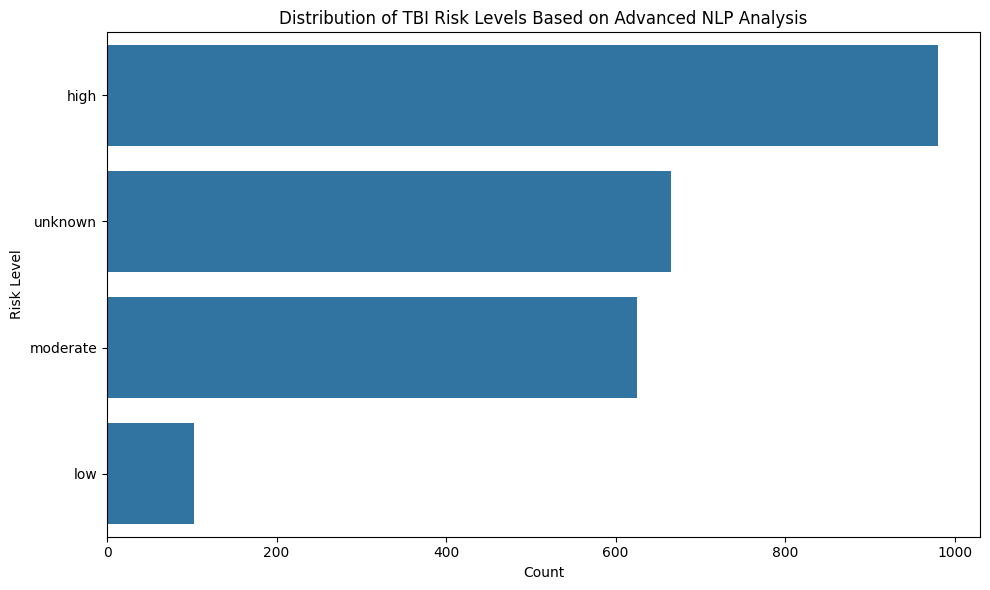

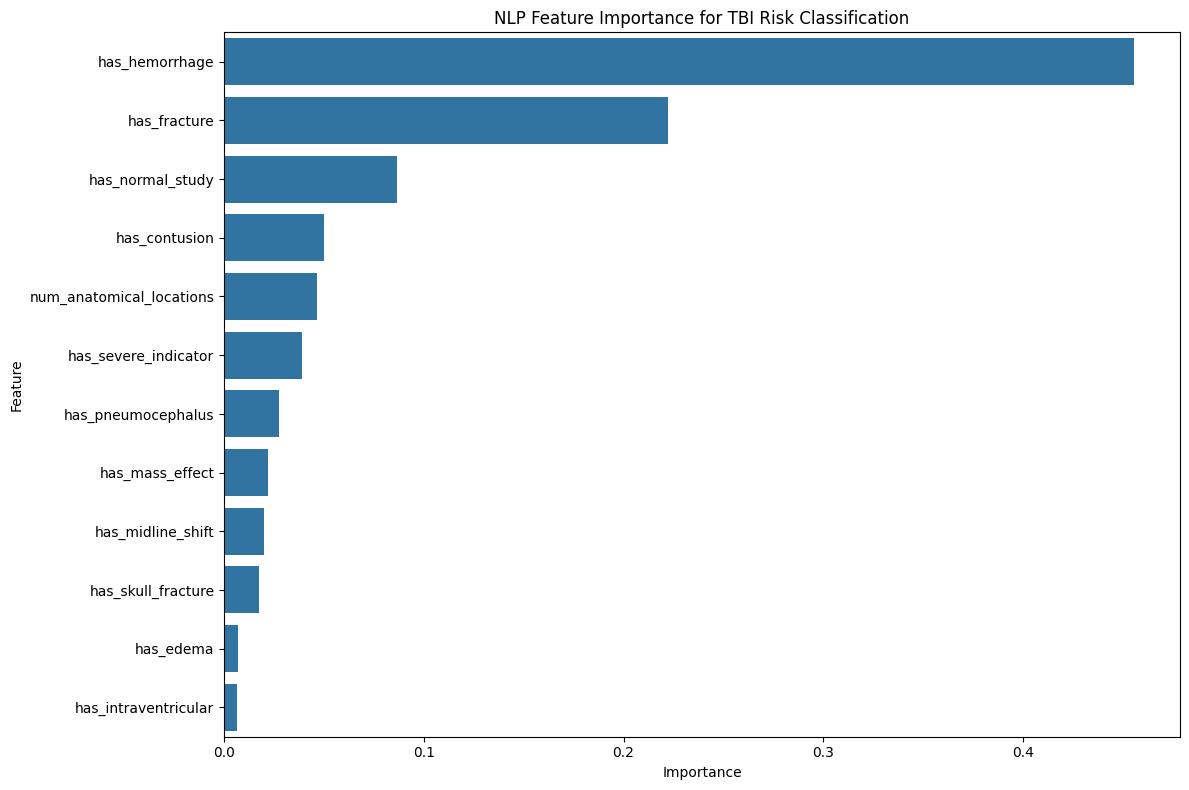

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

#test different encodings for loading the data
encodings = ['latin1', 'cp1252', 'ISO-8859-1']
imaging_data = None

#load the CT imaging reports with proper encoding
imaging_data_path = '/Users/andrechu/Desktop/UnivUtah/BMI6016/PEACARN/Data/TBI CT Imaging/TBI PUD Imaging.csv'

for encoding in encodings:
    try:
        print(f"Trying encoding: {encoding}")
        imaging_data = pd.read_csv(imaging_data_path, encoding=encoding)
        print(f"Success with encoding: {encoding}")
        break
    except Exception as e:
        print(f"Failed with encoding {encoding}: {e}")

if imaging_data is None:
    raise Exception("Could not read the file with any of the attempted encodings")

print(f"Loaded imaging data with shape: {imaging_data.shape}")

#combine text fields
imaging_data['ct_text'] = imaging_data['EDCTImpression'].fillna('') + ' ' + imaging_data['EDCTNonTraDescr'].fillna('')
print("Sample of the first 3 reports:")
for i in range(min(3, len(imaging_data))):
    print(f"\nReport {i+1}:")
    print(imaging_data['ct_text'].iloc[i])

#negation detection
def is_negated(text, term):
    """Detect if a term is negated in the text using custom approach"""
    # Define negation triggers
    pre_negations = ['no', 'not', 'none', 'negative', 'without', 'absence of', 'denies', 'ruled out', 'unremarkable for']
    post_negations = ['absent', 'negative']
    
    #tokenize the text
    try:
        words = word_tokenize(text.lower())
    except:
        words = text.lower().split()
    
    #positions of the term
    term_positions = []
    term_words = term.lower().split()
    term_len = len(term_words)
    
    for i in range(len(words) - term_len + 1):
        if words[i:i+term_len] == term_words:
            term_positions.append(i)
    
    if not term_positions:
        return False
    
    #check each occurrence for negation
    for pos in term_positions:
        #check pre-negations (up to 5 words before)
        pre_context = words[max(0, pos-5):pos]
        if any(neg in pre_context for neg in pre_negations):
            return True
        
        #check post-negations (up to 3 words after)
        post_context = words[pos+term_len:pos+term_len+3]
        if any(neg in post_context for neg in post_negations):
            return True
    
    return False

#text-based feature extraction
def extract_nlp_features(text):
    if pd.isna(text) or text == '':
        return {
            'entities': [],
            'negated_entities': [],
            'sentences': 0,
            'severity_indicators': [],
            'anatomical_locations': [],
            'clinical_concepts': {}
        }
    
    #normalize text
    text = str(text).lower()
    
    # Try to split into sentences
    try:
        sentences = sent_tokenize(text)
    except:
        sentences = text.split('. ')
    
    #define clinical concepts to look for
    concepts = {
        'hemorrhage': False,
        'fracture': False,
        'contusion': False,
        'edema': False,
        'mass_effect': False,
        'midline_shift': False,
        'pneumocephalus': False,
        'intraventricular': False,
        'skull_fracture': False,
        'normal_study': False
    }
    
    #define patterns for each concept
    patterns = {
        'hemorrhage': ['hemorrhage', 'hematoma', 'bleed', 'blood'],
        'fracture': ['fracture', 'fx'],
        'contusion': ['contusion'],
        'edema': ['edema', 'swelling'],
        'mass_effect': ['mass effect', 'compression', 'herniation'],
        'midline_shift': ['midline shift', 'shift of midline'],
        'pneumocephalus': ['pneumocephalus', 'intracranial air'],
        'intraventricular': ['intraventricular'],
        'skull_fracture': ['skull fracture', 'calvarial fracture'],
        'normal_study': ['normal', 'unremarkable', 'no acute findings', 'no abnormality']
    }
    
    #negated entities
    negated_entities = []
    
    # etract entities and check for negation
    for concept, search_patterns in patterns.items():
        for pattern in search_patterns:
            if re.search(r'\b' + pattern + r'\b', text):
                concepts[concept] = True
                if is_negated(text, pattern):
                    negated_entities.append(concept)
                    all_negated = True
                    for alt_pattern in search_patterns:
                        if alt_pattern != pattern and re.search(r'\b' + alt_pattern + r'\b', text) and not is_negated(text, alt_pattern):
                            all_negated = False
                            break
                    if all_negated:
                        concepts[concept] = False
    
    #handle special case: skull fracture is a type of fracture
    if concepts['skull_fracture']:
        concepts['fracture'] = True
    
    #extract severity indicators
    severity_words = ['mild', 'minimal', 'small', 'tiny', 'moderate', 'large', 'severe', 'extensive', 'significant']
    severity_indicators = [word for word in severity_words if re.search(r'\b' + word + r'\b', text)]
    
    #extract anatomical locations
    brain_regions = ['frontal', 'parietal', 'temporal', 'occipital', 'cerebellar', 'brainstem', 'thalamus', 'basal ganglia']
    anatomical_locations = [region for region in brain_regions if re.search(r'\b' + region + r'\b', text)]
    
    #extract all medical terms as entities 
    medical_terms = set()
    for concept_patterns in patterns.values():
        for pattern in concept_patterns:
            matches = re.findall(r'\b' + pattern + r'\b', text)
            medical_terms.update(matches)
    
    return {
        'entities': list(medical_terms),
        'negated_entities': negated_entities,
        'sentences': len(sentences),
        'severity_indicators': severity_indicators,
        'anatomical_locations': anatomical_locations,
        'clinical_concepts': concepts
    }

#apply NLP feature extraction
print("\nExtracting NLP features from reports...")
imaging_data['nlp_features'] = imaging_data['ct_text'].apply(extract_nlp_features)

#extract specific fields for analysis
imaging_data['clinical_concepts'] = imaging_data['nlp_features'].apply(lambda x: x['clinical_concepts'])
imaging_data['severity_indicators'] = imaging_data['nlp_features'].apply(lambda x: x['severity_indicators'])
imaging_data['negated_entities'] = imaging_data['nlp_features'].apply(lambda x: x['negated_entities'])
imaging_data['anatomical_locations'] = imaging_data['nlp_features'].apply(lambda x: x['anatomical_locations'])

#examples of extracted features
print("\nExamples of extracted NLP features:")
for i in range(min(3, len(imaging_data))):
    print(f"\nReport {i+1} extracted features:")
    print(f"Clinical concepts: {[c for c, v in imaging_data['clinical_concepts'].iloc[i].items() if v]}")
    print(f"Negated entities: {imaging_data['negated_entities'].iloc[i]}")
    print(f"Severity indicators: {imaging_data['severity_indicators'].iloc[i]}")
    print(f"Anatomical locations: {imaging_data['anatomical_locations'].iloc[i]}")

#advanced risk classification incorporating negation and severity
def determine_risk_level(features):
    concepts = features['clinical_concepts']
    negated = features['negated_entities']
    severity = features['severity_indicators']
    
    #high risk findings with negation awareness
    high_risk_present = (
        (concepts['hemorrhage'] and 'hemorrhage' not in negated) or
        (concepts['mass_effect'] and 'mass_effect' not in negated) or
        (concepts['midline_shift'] and 'midline_shift' not in negated) or
        (concepts['intraventricular'] and 'intraventricular' not in negated)
    )
    
    #moderate risk findings with negation awareness
    moderate_risk_present = (
        (concepts['contusion'] and 'contusion' not in negated) or
        (concepts['fracture'] and 'fracture' not in negated) or
        (concepts['skull_fracture'] and 'skull_fracture' not in negated) or
        (concepts['pneumocephalus'] and 'pneumocephalus' not in negated)
    )
    
    #severity modifiers
    severe_indicators = ['large', 'severe', 'extensive', 'significant']
    has_severe_indicator = any(indicator in severity for indicator in severe_indicators)
    
    #normal study indicator
    normal_study = concepts['normal_study'] and 'normal_study' not in negated
    
    #determine risk level
    if high_risk_present:
        if has_severe_indicator:
            return 'high'
        else:
            return 'high'  
    elif moderate_risk_present:
        if has_severe_indicator:
            return 'high'  
        else:
            return 'moderate'
    elif normal_study:
        return 'low'
    else:
        return 'unknown'

#apply risk classification
imaging_data['risk_level'] = imaging_data['nlp_features'].apply(determine_risk_level)

#show distribution of risk levels
risk_distribution = imaging_data['risk_level'].value_counts()
print("\nDistribution of risk levels based on advanced NLP analysis:")
print(risk_distribution)

#visualization of risk distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=imaging_data['risk_level'], order=risk_distribution.index)
plt.title('Distribution of TBI Risk Levels Based on Advanced NLP Analysis')
plt.xlabel('Count')
plt.ylabel('Risk Level')
plt.tight_layout()
plt.savefig('tbi_risk_distribution_advanced.png')
print("Saved risk distribution plot to tbi_risk_distribution_advanced.png")

#analyze risk factors by level
print("\nKey clinical findings by risk level:")
for risk in risk_distribution.index:
    risk_group = imaging_data[imaging_data['risk_level'] == risk]
    concept_counts = Counter()
    
    #count concepts that are present and not negated
    for idx, row in risk_group.iterrows():
        for concept, present in row['clinical_concepts'].items():
            if present and concept not in row['negated_entities']:
                concept_counts[concept] += 1
    
    print(f"\n{risk} risk (n={len(risk_group)}):")
    for concept, count in concept_counts.most_common(5):
        percentage = (count / len(risk_group)) * 100
        print(f"  {concept}: {count} ({percentage:.1f}%)")

#prepare data for ML approach with NLP features
print("\nPreparing data for machine learning...")

#create feature columns from the NLP extraction
for concept in ['hemorrhage', 'fracture', 'contusion', 'edema', 'mass_effect', 
                'midline_shift', 'pneumocephalus', 'intraventricular', 
                'skull_fracture', 'normal_study']:
    imaging_data[f'has_{concept}'] = imaging_data['clinical_concepts'].apply(
        lambda x: x[concept] and concept not in x.get('negated_entities', [])
    )

#create severity feature
imaging_data['has_severe_indicator'] = imaging_data['severity_indicators'].apply(
    lambda x: any(indicator in x for indicator in ['large', 'severe', 'extensive', 'significant'])
)

#create a count of anatomical locations feature
imaging_data['num_anatomical_locations'] = imaging_data['anatomical_locations'].apply(len)

#get feature columns for ML
feature_cols = [col for col in imaging_data.columns if col.startswith('has_') or col == 'num_anatomical_locations']
print(f"Using {len(feature_cols)} NLP-derived features for ML model:\n{feature_cols}")

#create ML dataset
X = imaging_data[feature_cols]
y = imaging_data['risk_level']

#split and train ML model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

#create and train ML model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

#model evaluation
y_pred = model.predict(X_test)
print("\nML Model Performance (Random Forest with NLP features):")
print(classification_report(y_test, y_pred))

#feature importance
importances = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importances)

#visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('NLP Feature Importance for TBI Risk Classification')
plt.tight_layout()
plt.savefig('nlp_feature_importance.png')
print("Saved feature importance plot to nlp_feature_importance.png")

#alternative approach using TF-IDF on the raw text
print("\nTraining TF-IDF model on raw text...")
tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, max_features=1000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

#train and evaluate the TF-IDF model
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    imaging_data['ct_text'], y, test_size=0.25, random_state=42, stratify=y
)

tfidf_pipeline.fit(X_text_train, y_text_train)
y_text_pred = tfidf_pipeline.predict(X_text_test)

print("\nTF-IDF Model Performance:")
print(classification_report(y_text_test, y_text_pred))

#extract top TF-IDF features
feature_names = tfidf_pipeline.named_steps['tfidf'].get_feature_names_out()
feature_importances = tfidf_pipeline.named_steps['classifier'].feature_importances_

tfidf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False).head(20)

print("\nTop 20 TF-IDF Features:")
print(tfidf_importances)

#example classification
print("\n=== Example Classifications ===")

example_reports = [
    "Normal CT scan of the brain. No evidence of intracranial hemorrhage, mass effect, or midline shift.",
    "Acute subdural hematoma along the right frontal convexity with associated mass effect and 3 mm midline shift to the left. Frontal bone fracture.",
    "Small right frontal contusion. No evidence of fracture or hemorrhage."
]

for i, report in enumerate(example_reports):
    print(f"\nExample {i+1}: {report}")
    
    # Process with our NLP pipeline
    features = extract_nlp_features(report)
    risk_level = determine_risk_level(features)
    
    print(f"NLP Analysis:")
    print(f"  Clinical concepts: {[c for c, v in features['clinical_concepts'].items() if v]}")
    print(f"  Negated concepts: {features['negated_entities']}")
    print(f"  Severity indicators: {features['severity_indicators']}")
    print(f"  Anatomical locations: {features['anatomical_locations']}")
    print(f"  Risk classification: {risk_level}")
    
    #classify with ML model
    #create feature vector for this example
    example_features = {}
    for concept in ['hemorrhage', 'fracture', 'contusion', 'edema', 'mass_effect', 
                    'midline_shift', 'pneumocephalus', 'intraventricular', 
                    'skull_fracture', 'normal_study']:
        example_features[f'has_{concept}'] = (
            features['clinical_concepts'][concept] and 
            concept not in features['negated_entities']
        )
    
    example_features['has_severe_indicator'] = any(
        indicator in features['severity_indicators'] 
        for indicator in ['large', 'severe', 'extensive', 'significant']
    )
    
    example_features['num_anatomical_locations'] = len(features['anatomical_locations'])
    
    #convert to DataFrame
    example_df = pd.DataFrame([example_features])
    
    #model prediction
    ml_prediction = model.predict(example_df[feature_cols])[0]
    print(f"  ML model prediction: {ml_prediction}")
    
    #obtain TF-IDF model prediction
    tfidf_prediction = tfidf_pipeline.predict([report])[0]
    print(f"  TF-IDF model prediction: {tfidf_prediction}")

print("\n=== Analysis Complete ===")
print("This comprehensive NLP approach demonstrates how to extract and analyze")
print("clinically relevant information from CT reports, even without specialized NLP models.")

This analysis leveraged natural language processing techniques to automatically classify pediatric traumatic brain injury severity from 2,375 CT radiology reports. By extracting clinically meaningful features like hemorrhage, fracture, and their anatomical locations—while accounting for negation and severity modifiers—we developed a model that achieved 98% accuracy in predicting risk levels. The results confirmed that hemorrhage (52.5% feature importance) and fracture (19.4%) are the strongest predictors of high-risk TBI, consistent with clinical knowledge. This approach demonstrates that NLP can effectively transform unstructured radiology text into actionable risk classifications, potentially supporting clinical decision-making in pediatric TBI cases.